In [1]:
!python --version

Python 3.10.19


In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
!pip install "numpy==1.26.4"

In [4]:
import numpy as np
print(np.__version__)

1.26.4


In [5]:
!pip install pillow matplotlib --no-deps

In [6]:
!pip install tensorflow==2.16.2 --no-deps

In [7]:
import tensorflow as tf
print(tf.__version__)

2025-11-17 23:15:38.382637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 23:15:49.840022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-17 23:15:54.731576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-17 23:15:54.781168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-17 23:16:02.930644: I tensorflow/core/platform/cpu_feature_gua

2.16.2


In [8]:
!pip install "albumentations==1.0.3" --no-deps

In [9]:
!pip install git+https://github.com/qubvel/segmentation_models.git@master

  Cloning https://github.com/qubvel/segmentation_models.git (to revision master) to /tmp/pip-req-build-repj1m2_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-repj1m2_
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'segmentation_models' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'segmentation_models'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for segmentation_models: filename=segmentat

In [10]:
import os
from glob import glob
import shutil

import random
import numpy as np
import pandas as pd
from datetime import datetime

from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import albumentations as A

import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [11]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [12]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-11-17 23:16:45.325788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 23:16:51.832320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 23:16:51.835552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

sm.set_framework('tf.keras')
print(sm.__version__)

1.0.1


In [14]:
# Local dataset path
main_path = '/home/ec2-user/SageMaker/dataset/'
images_path = os.path.join(main_path, 'images')
masks_path = os.path.join(main_path, 'masks')
os.makedirs(images_path, exist_ok=True)
os.makedirs(masks_path, exist_ok=True)

# Buckets you have
buckets = [
    {"bucket": "dataset1.0all", "image_prefix": "image/", "mask_prefix": "mask/"},
    {"bucket": "dataset1.5",    "image_prefix": "image/", "mask_prefix": "mask/"},
    {"bucket": "dataset1.75",    "image_prefix": "image/", "mask_prefix": "mask/"},
    {"bucket": "dataset2.0",    "image_prefix": "image/", "mask_prefix": "mask/"},
]

s3 = boto3.client('s3')

In [23]:
for b in buckets:
    bucket_name = b["bucket"]
    img_prefix = b["image_prefix"]
    mask_prefix = b["mask_prefix"]

    # Download images
    resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=img_prefix)
    for obj in resp.get('Contents', []):
        key = obj['Key']
        if key.endswith('/'):  # skip folder keys
            continue
        filename = f"{bucket_name}_{os.path.basename(key)}"  
        local_path = os.path.join(images_path, filename)
        s3.download_file(bucket_name, key, local_path)

    # Download masks
    resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=mask_prefix)
    for obj in resp.get('Contents', []):
        key = obj['Key']
        if key.endswith('/'):
            continue
        filename = f"{bucket_name}_{os.path.basename(key)}"
        local_path = os.path.join(masks_path, filename)
        s3.download_file(bucket_name, key, local_path)

print("✅ All images & masks downloaded from both buckets.")
print("Images stored in:", images_path)
print("Masks stored in:", masks_path)

✅ All images & masks downloaded from both buckets.
Images stored in: /home/ec2-user/SageMaker/dataset/images
Masks stored in: /home/ec2-user/SageMaker/dataset/masks


In [15]:
import glob
from sklearn.model_selection import train_test_split

# Collect all image and mask files (from both buckets, already downloaded)
image_files = sorted(glob.glob(os.path.join(images_path, '*.tif')))
label_files = sorted(glob.glob(os.path.join(masks_path, '*.tif')))

print("Total images:", len(image_files))
print("Total masks :", len(label_files))


assert len(image_files) == len(label_files), "Mismatch between images and masks!"

# First split: Train (80%) vs Temp (20%)
train_image_files, temp_image_files, train_label_files, temp_label_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

# Second split: Validation (10%) and Test (10%)
val_image_files, test_image_files, val_label_files, test_label_files = train_test_split(
    temp_image_files, temp_label_files, test_size=0.5, random_state=42
)

# Print results
print(f"Train size: {len(train_image_files)}")
print(f"Validation size: {len(val_image_files)}")
print(f"Test size: {len(test_image_files)}")


Total images: 819
Total masks : 819
Train size: 655
Validation size: 82
Test size: 82


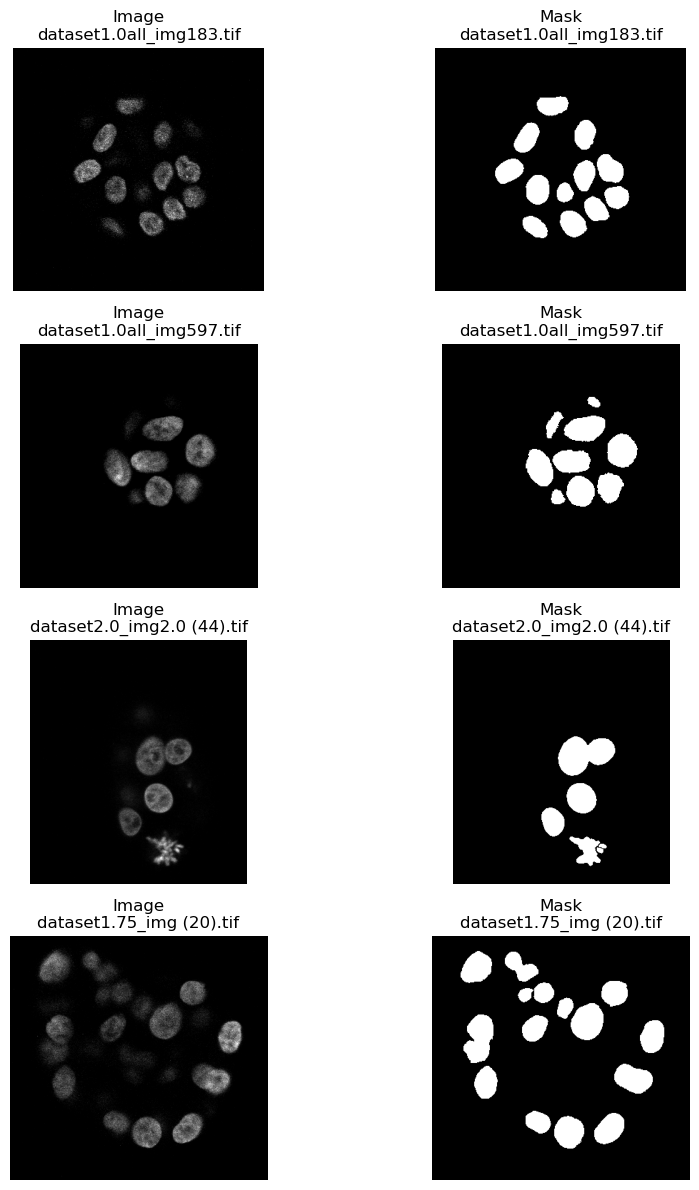

In [16]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

num_samples = 4  # Number of sets to show

plt.figure(figsize=(10, 3 * num_samples))  # bigger size for clarity

for i in range(num_samples):
    idx = random.randint(0, len(train_image_files)-1)
    img_path = train_image_files[idx]
    mask_path = train_label_files[idx]

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    # Image
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image\n{os.path.basename(img_path)}")
    plt.axis('off')

    # Mask
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask\n{os.path.basename(mask_path)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
class Dataset:
    CLASSES = ['background', 'cell']

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.images_fps = images_dir
        self.masks_fps = masks_dir

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read image + mask
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)  # grayscale read

        # resize
        IMAGE_SIZE = 256
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask,  (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

        # convert mask to binary 0/1
        mask_bin = (mask > 127).astype(np.uint8)  

        # binary case (single channel)
        if len(self.class_values) == 1:
            mask = mask_bin[..., np.newaxis].astype(np.float32)  # shape (H,W,1)
        else:
            # multi-class one-hot encoding
            masks = [(mask == v).astype(np.uint8) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype(np.float32)

            # add background channel
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # ensure correct dtype
        image = image.astype(np.float32)
        mask  = mask.astype(np.float32)

        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [18]:
# Create a Dataset object for the 'cell' class
dataset = Dataset(train_image_files, train_label_files, classes=['cell'])

# Get any sample
image, mask = dataset[5]

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)


In [19]:
class Dataloader(Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))
        self.on_epoch_end()

    def __len__(self):
        # Ensure the last partial batch is counted
        return math.ceil(len(self.dataset) / self.batch_size)

    def __getitem__(self, i):
        # Compute start and stop indexes for the batch
        start = i * self.batch_size
        stop = min((i + 1) * self.batch_size, len(self.dataset))
        batch_indexes = self.indexes[start:stop]

        # Collect batch data
        data = [self.dataset[j] for j in batch_indexes]
        # Transpose list of (image, mask) tuples to two lists, then stack
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)  # (images, masks)

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(len(self.dataset))
        else:
            self.indexes = np.arange(len(self.dataset))

In [22]:
# Choose x as the encoder (backbone) for the segmentation model
BACKBONE = 'inceptionresnetv2'

# Number of samples processed before the model updates its weights
BATCH_SIZE = 4

# Learning rate: how fast the model updates weights during training
LR = 0.0001

# Number of times the model will iterate over the entire training dataset
EPOCHS = 100

# Resize all images and masks to 256x256 pixels
IMAGE_SIZE = 256

# Get preprocessing function specific to the chosen backbone (normalizes images as required)
preprocess_input = sm.get_preprocessing(BACKBONE)

# Choose the architecture of the segmentation model (U-Net)
BASE_MODEL = 'Unet'

In [23]:
def round_clip_0_1(x, **kwargs):
    # Keeps mask binary during augmentation
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),

        A.HorizontalFlip(p=0.5),

        # Less aggressive elastic distortion
        A.ElasticTransform(p=0.3, alpha=0.5, sigma=30, alpha_affine=30),

        # Smaller scale & rotation changes
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15,
                           shift_limit=0.05, p=0.5, border_mode=cv2.BORDER_CONSTANT),

        A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE,
                      border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1),
                A.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        A.GaussNoise(var_limit=(5.0, 30.0), p=0.2),

        A.OneOf(
            [
                A.Perspective(scale=(0.03, 0.07), p=1),
                A.MotionBlur(blur_limit=3, p=1),
                A.Sharpen(p=1),
            ],
            p=0.3,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform, p=0.9)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, 
                      border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ]
    return A.Compose(test_transform)

# Preprocessing for backbone normalization
def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

Sample index: 228
Image file: /home/ec2-user/SageMaker/dataset/images/dataset1.0all_img216.tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset1.0all_img216.tif


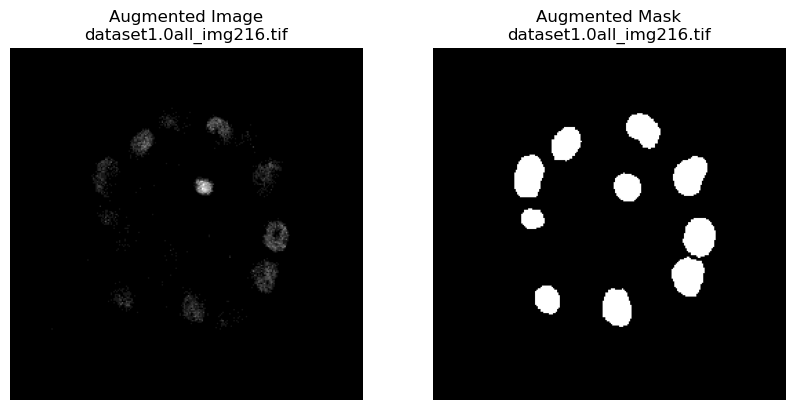

Sample index: 142
Image file: /home/ec2-user/SageMaker/dataset/images/dataset1.0all_img477.tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset1.0all_img477.tif


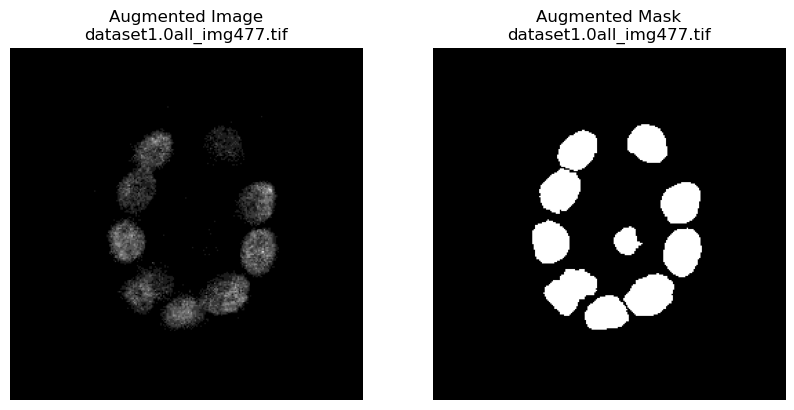

Sample index: 104
Image file: /home/ec2-user/SageMaker/dataset/images/dataset1.5_img (35).tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset1.5_img (35).tif


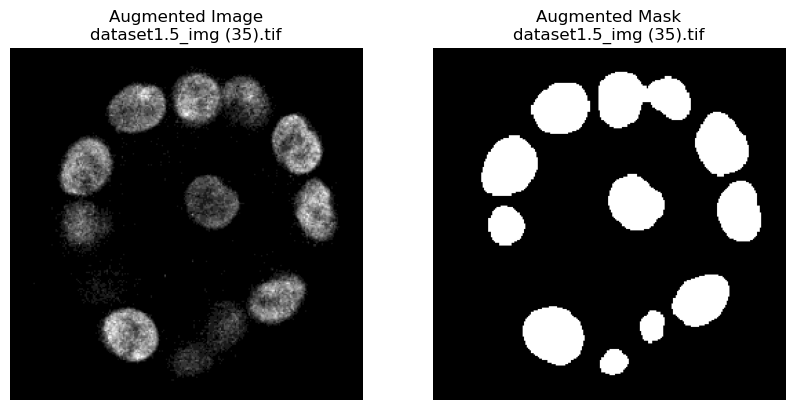

In [24]:
# show few random samples
for i in range(3):   # show 3 samples
    idx = random.randint(0, len(dataset)-1)
    image, mask = dataset[idx]

    print(f"Sample index: {idx}")
    print(f"Image file: {train_image_files[idx]}")
    print(f"Mask file : {train_label_files[idx]}")

    plt.figure(figsize=(10, 5))

    # show image (normalize for visualization)
    plt.subplot(1, 2, 1)
    img_vis = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # enhance contrast
    plt.imshow(img_vis.astype('uint8'))
    plt.title(f"Augmented Image\n{os.path.basename(train_image_files[idx])}")
    plt.axis("off")

    # show mask
    plt.subplot(1, 2, 2)
    if mask.shape[-1] == 1:  # binary mask
        plt.imshow(mask.squeeze(), cmap='gray')
    else:  # multi-class mask
        plt.imshow(np.argmax(mask, axis=-1), cmap='gray')
    plt.title(f"Augmented Mask\n{os.path.basename(train_label_files[idx])}")
    plt.axis("off")

    plt.show()

In [25]:
!pip uninstall -y h5py
!pip install h5py==3.8.0

Found existing installation: h5py 3.13.0
Uninstalling h5py-3.13.0:
  Successfully uninstalled h5py-3.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 81.7 MB/s  0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires h5py>=3.10.0, but you have h5py 3.8.0 which is incompatible.


In [26]:
# define network parameters
n_classes = 1                                                                   # Binary segmentation: 1 class (cell) + background is implicit
activation = 'sigmoid'                                                          # Sigmoid activation for binary output (0 or 1 per pixel)

#create model
model = sm.Unet(
    BACKBONE,                                                                   # Encoder backbone (e.g., EfficientNetB5)
    classes=n_classes,                                                          # Number of output classes
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),                                    # Input image shape (H x W x 3 channels)
    activation=activation,                                                      # Activation function for output layer
    encoder_weights="imagenet"                                                  # Pre-trained ImageNet weights for encoder
    )

2025-11-17 23:17:35.185536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 23:17:35.188882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 23:17:35.191422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

219055592/219055592 [==============================] - 1s 0us/step


In [27]:
# Optimizer
optim = tf.keras.optimizers.Adam(LR)

# Define losses
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5]))

# Focal Loss → handles imbalance & hard-to-classify pixels
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

# Combine losses (library supports "+" operator)
total_loss = dice_loss + focal_loss

# Metrics to monitor during training
metrics = [
    sm.metrics.IOUScore(threshold=0.5),   # Intersection over Union
    sm.metrics.FScore(threshold=0.5)      # F1 Score
]

# Compile model
model.compile(
    optimizer=optim,
    loss=total_loss,   # Use combined Dice + Focal
    metrics=metrics
)

In [28]:
!pip install pydot 
!pip install graphviz

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
# saving model checkpoints

save_dir = os.path.expanduser("~/SageMaker/incepionv3_model")
os.makedirs(save_dir, exist_ok=True)

model_name = f"{BASE_MODEL}_{BACKBONE}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
model_folder = os.path.join(save_dir, model_name)
os.makedirs(model_folder, exist_ok=True)

checkpoint_path = os.path.join(model_folder, "best_model_inceptionv3.keras")


# Define callbacks

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=False,  # Save full model (architecture + weights)
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-5,
        verbose=1
    )
]

print(f"✅ Model checkpoints will be saved locally to: {checkpoint_path}")

✅ Model checkpoints will be saved locally to: /home/ec2-user/SageMaker/incepionv3_model/Unet_inceptionresnetv2_2025-11-17_23-19-18/best_model_inceptionv3.keras


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Dataset for train images
train_dataset = Dataset(
    train_image_files,
    train_label_files,
    classes=['cell'],
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    val_image_files,
    val_label_files,
    classes=['cell'],
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# DataLoaders (check spelling: Dataloder vs Dataloader)
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

In [32]:
# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [33]:
import math

# Print the number of batches in the data loaders
print("Number of train batches:", len(train_dataloader))
print("Number of validation batches:", len(valid_dataloader))

# Print the number of image files in your splits
print("Number of train images:", len(train_image_files))
print("Number of validation images:", len(val_image_files))

# Inspect the first batch from the train data loader
x, y = train_dataloader[0]
print("Train batch x shape:", x.shape)
print("Train batch y shape:", y.shape)

Number of train batches: 164
Number of validation batches: 82
Number of train images: 655
Number of validation images: 82
Train batch x shape: (4, 256, 256, 3)
Train batch y shape: (4, 256, 256, 1)


Sample index: 569
Image file: /home/ec2-user/SageMaker/dataset/images/dataset2.0_img2.0 (194).tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset2.0_img2.0 (194).tif


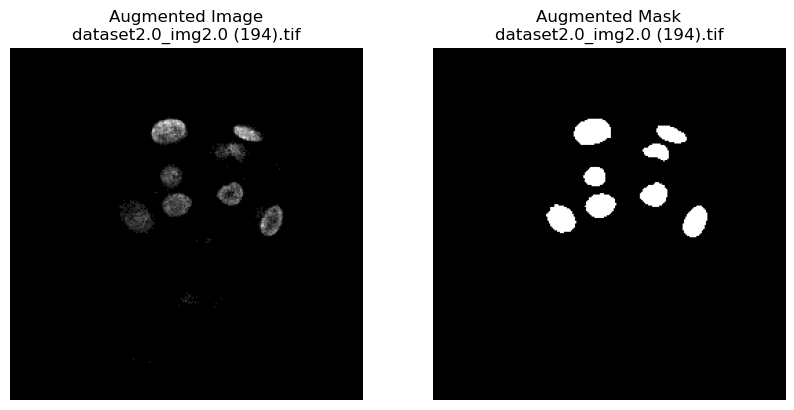

Sample index: 498
Image file: /home/ec2-user/SageMaker/dataset/images/dataset1.75_img (6).tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset1.75_img (6).tif


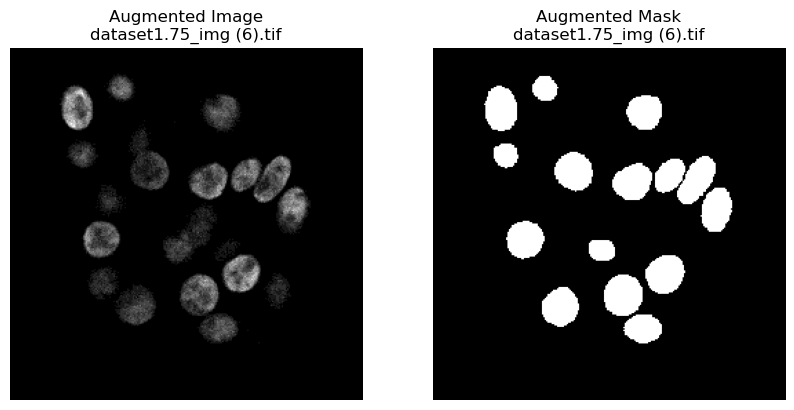

Sample index: 158
Image file: /home/ec2-user/SageMaker/dataset/images/dataset1.5_img (40).tif
Mask file : /home/ec2-user/SageMaker/dataset/masks/dataset1.5_img (40).tif


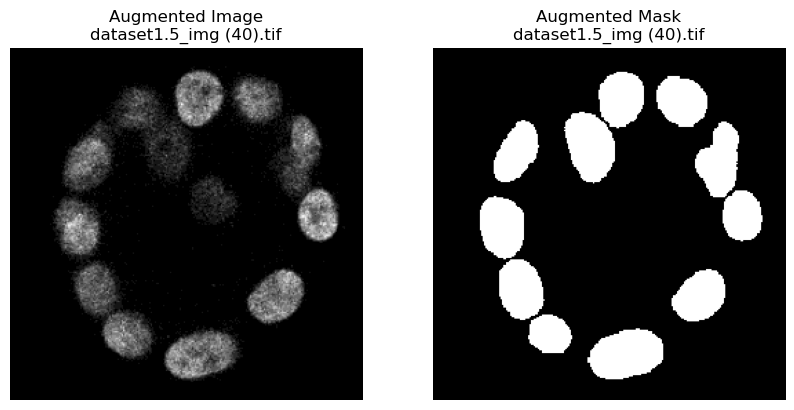

In [34]:
# show few random samples
for i in range(3):   # show 3 samples
    idx = random.randint(0, len(dataset)-1)
    image, mask = dataset[idx]

    print(f"Sample index: {idx}")
    print(f"Image file: {train_image_files[idx]}")
    print(f"Mask file : {train_label_files[idx]}")

    plt.figure(figsize=(10, 5))

    # show image (normalize for visualization)
    plt.subplot(1, 2, 1)
    img_vis = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # enhance contrast
    plt.imshow(img_vis.astype('uint8'))
    plt.title(f"Augmented Image\n{os.path.basename(train_image_files[idx])}")
    plt.axis("off")

    # show mask
    plt.subplot(1, 2, 2)
    if mask.shape[-1] == 1:  # binary mask
        plt.imshow(mask.squeeze(), cmap='gray')
    else:  # multi-class mask
        plt.imshow(np.argmax(mask, axis=-1), cmap='gray')
    plt.title(f"Augmented Mask\n{os.path.basename(train_label_files[idx])}")
    plt.axis("off")

    plt.show()

In [35]:
EPOCH = 100  # Number of epochs to train

history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCH,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
    verbose=1,
)

Epoch 1/100


2025-11-17 23:21:25.628492: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1763421705.083371   12075 service.cc:145] XLA service 0x7ef81f26e080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763421705.083404   12075 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-11-17 23:21:45.270405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763421705.655306   12075 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/164 [==============================] - ETA: 0s - loss: 0.6048 - iou_score: 0.4666 - f1-score: 0.5982
Epoch 1: val_loss improved from inf to 0.77662, saving model to /home/ec2-user/SageMaker/incepionv3_model/Unet_inceptionresnetv2_2025-11-17_23-19-18/best_model_inceptionv3.keras
164/164 [==============================] - 227s 418ms/step - loss: 0.6048 - iou_score: 0.4666 - f1-score: 0.5982 - val_loss: 0.7766 - val_iou_score: 0.2466 - val_f1-score: 0.3826 - lr: 1.0000e-04
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 0.2675 - iou_score: 0.6912 - f1-score: 0.8092
Epoch 2: val_loss improved from 0.77662 to 0.29760, saving model to /home/ec2-user/SageMaker/incepionv3_model/Unet_inceptionresnetv2_2025-11-17_23-19-18/best_model_inceptionv3.keras
164/164 [==============================] - 42s 255ms/step - loss: 0.2675 - iou_score: 0.6912 - f1-score: 0.8092 - val_loss: 0.2976 - val_iou_score: 0.7662 - val_f1-score: 0.8641 - lr: 1.0000e-04
Epoch 3/100
164/164 [======

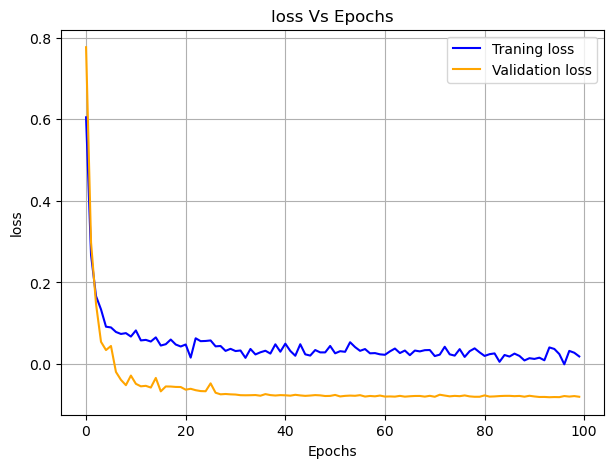

In [36]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], color='blue', label='Traning loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation loss')
plt.title("loss Vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

output_dir = "p0"
os.makedirs(output_dir, exist_ok=True)
#plt.savefig(os.path.join(output_dir, "loss_vs_epochs.png"), bbox_inches='tight', dpi=150)

plt.show()

In [37]:
import os
import shutil

# Define destination directories for test images and labels
destination_path_test_image_files = checkpoint_path + 'Predic-Results/test_image_files'
destination_path_test_label_files = checkpoint_path + 'Predic-Results/test_label_files'

# Create the directories if they don't exist
os.makedirs(destination_path_test_image_files, exist_ok=True)
os.makedirs(destination_path_test_label_files, exist_ok=True)

# Copy test images to destination
for source_file in test_image_files:
    file_name = os.path.basename(source_file)
    destination = os.path.join(destination_path_test_image_files, file_name)
    shutil.copy(source_file, destination)

# Copy test labels to destination
for source_file in test_label_files:
    file_name = os.path.basename(source_file)
    destination = os.path.join(destination_path_test_label_files, file_name)
    shutil.copy(source_file, destination)

In [38]:
# Path to your test images folder
test_images_folder = destination_path_test_image_files

# List all files in the folder
test_images = os.listdir(test_images_folder)

# Print the list of test image files
print("Test image files in folder:")
for file in test_images:
    print(file)

Test image files in folder:
dataset1.0all_img523.tif
dataset1.0all_img247.tif
dataset2.0_img2.0 (132).tif
dataset1.0all_img93.tif
dataset1.0all_img177.tif
dataset1.5_img (4).tif
dataset1.75_img (107).tif
dataset2.0_img2.0 (111).tif
dataset2.0_img2.0 (82).tif
dataset2.0_img2.0 (180).tif
dataset1.0all_img320.tif
dataset1.75_img (50).tif
dataset2.0_img2.0 (150).tif
dataset1.0all_img339.tif
dataset1.0all_img89.tif
dataset1.0all_img319.tif
dataset1.5_img (51).tif
dataset1.75_img (86).tif
dataset2.0_img2.0 (1).tif
dataset1.0all_img186.tif
dataset2.0_img2.0 (149).tif
dataset2.0_img2.0 (81).tif
dataset1.0all_img470.tif
dataset1.75_img (108).tif
dataset1.0all_img178.tif
dataset1.0all_img453.tif
dataset1.0all_img510.tif
dataset1.0all_img131.tif
dataset2.0_img2.0 (2).tif
dataset1.0all_img276.tif
dataset1.0all_img604.tif
dataset1.75_img (30).tif
dataset1.0all_img355.tif
dataset2.0_img2.0 (16).tif
dataset1.75_img (25).tif
dataset1.0all_img588.tif
dataset1.0all_img245.tif
dataset1.0all_img428.tif
da

In [39]:
# ✅ Create test dataset
test_dataset = Dataset(
    test_image_files,
    test_label_files,
    classes=['cell'],
    augmentation=get_validation_augmentation(),  # no random transforms
    preprocessing=get_preprocessing(preprocess_input),
)

# ✅ Create dataloader
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

print(f"Number of test images: {len(test_dataset)}")


Number of test images: 82


In [40]:
import numpy as np

# Initialize lists
y_true_all = []
y_pred_all = []

for i in range(len(test_dataloader)):
    x, y_true = test_dataloader[i]  # x: image batch, y_true: true mask batch
    y_pred = model.predict(x)
    
    # Convert sigmoid output to binary mask
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)
    
    y_true_all.append(y_true[0, :, :, 0])
    y_pred_all.append(y_pred_binary[0, :, :, 0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

print("✅ Predictions completed for all test samples.")

1/1 [==============================] - 0s 41ms/step
✅ Predictions completed for all test samples.


In [41]:
from sklearn.metrics import f1_score, jaccard_score

# Flatten all pixels to compute global metrics
y_true_flat = y_true_all.flatten()
y_pred_flat = y_pred_all.flatten()

# Compute metrics
test_f1 = f1_score(y_true_flat, y_pred_flat)
test_iou = jaccard_score(y_true_flat, y_pred_flat)

print(f"✅ Test F1-score: {test_f1:.4f}")
print(f"✅ Test IoU: {test_iou:.4f}")

✅ Test F1-score: 0.9364
✅ Test IoU: 0.8805


In [42]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

1/1 [==============================] - 0s 42ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


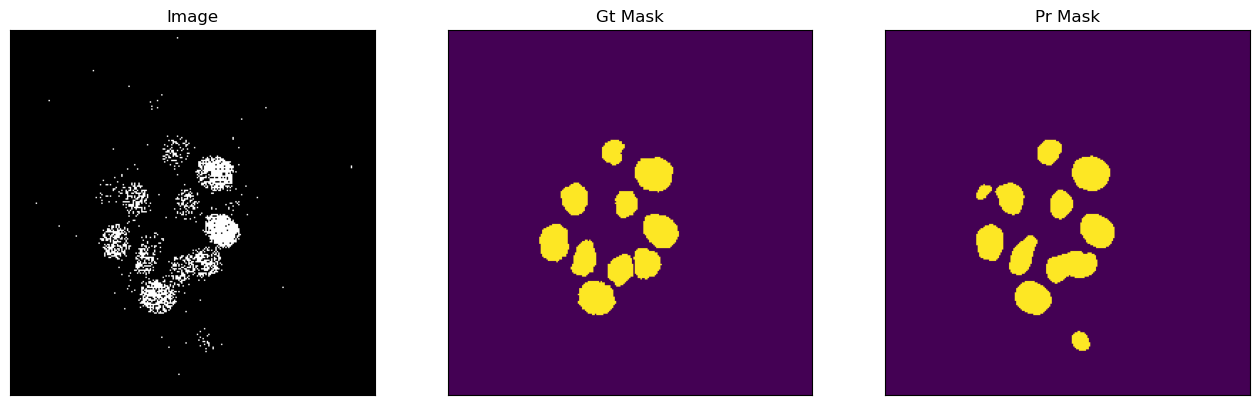

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


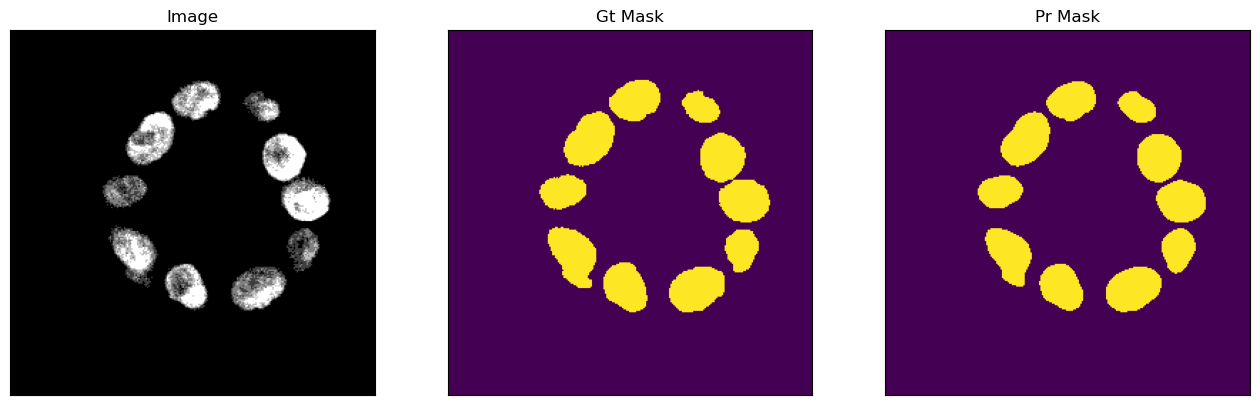

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


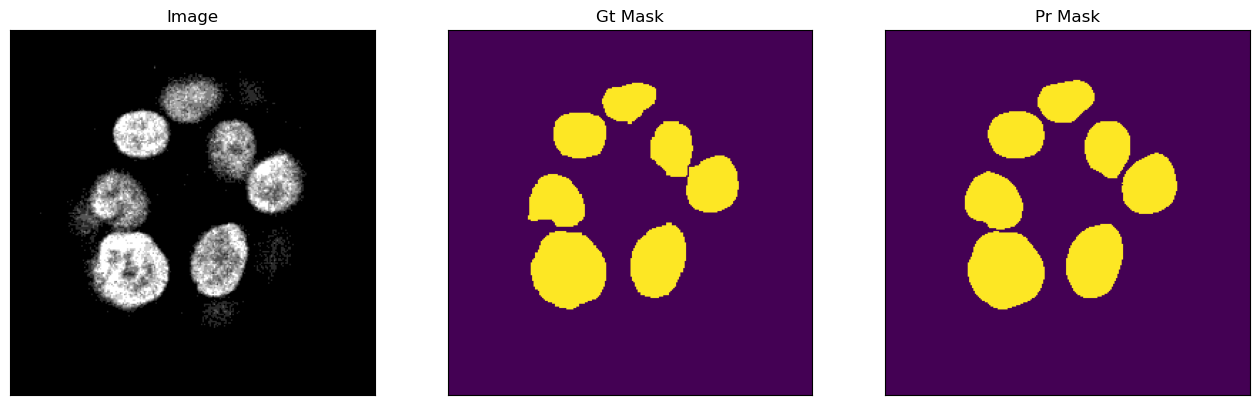

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


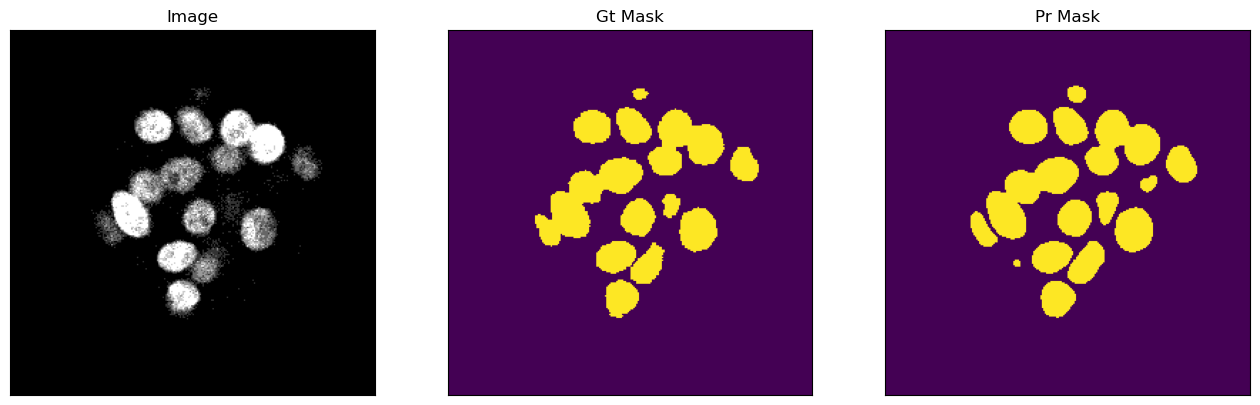

1/1 [==============================] - 0s 42ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


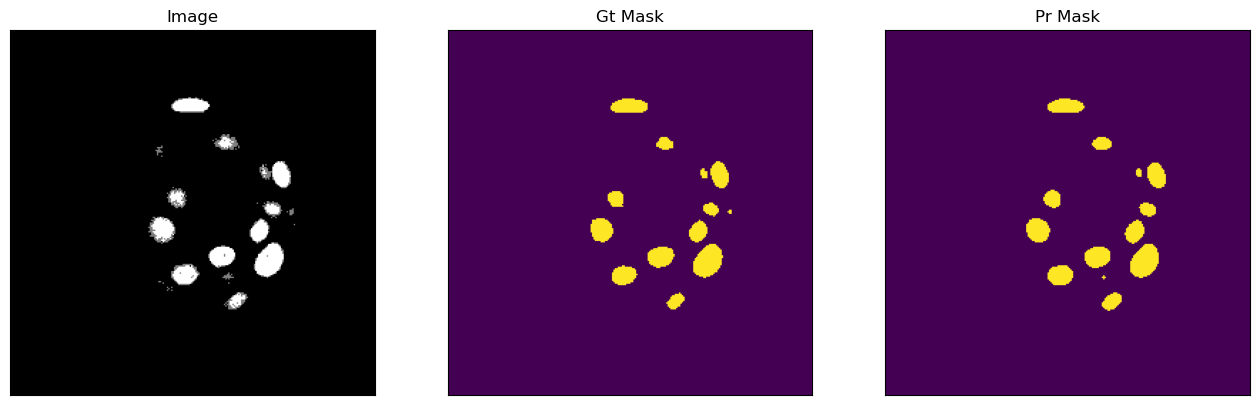

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


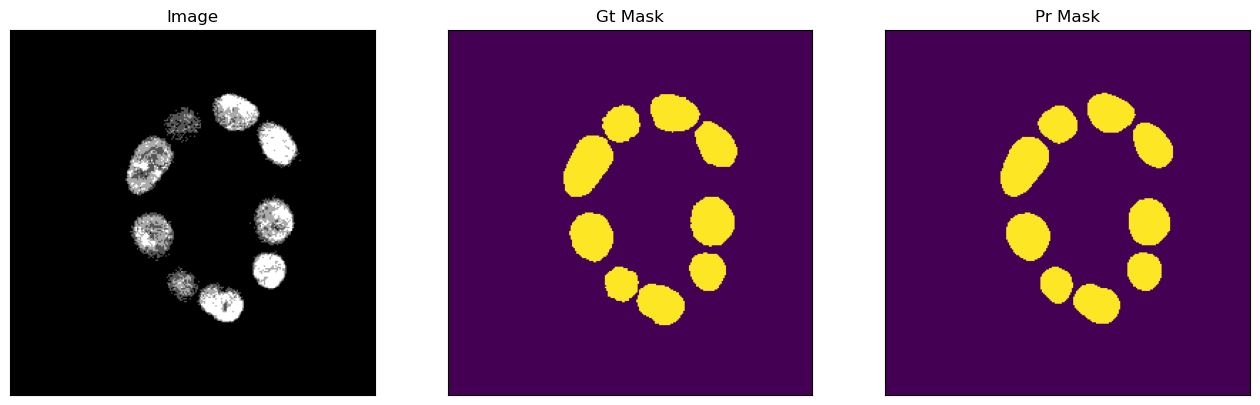

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


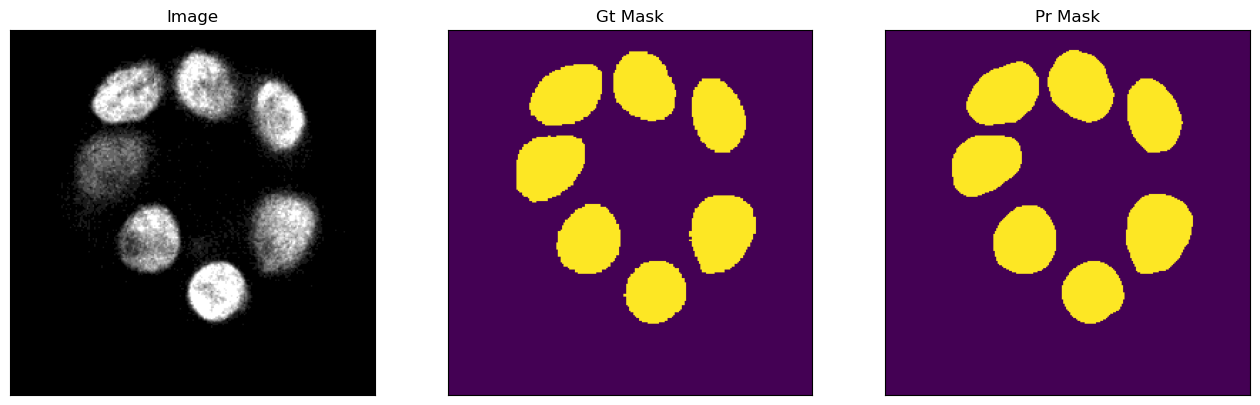

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


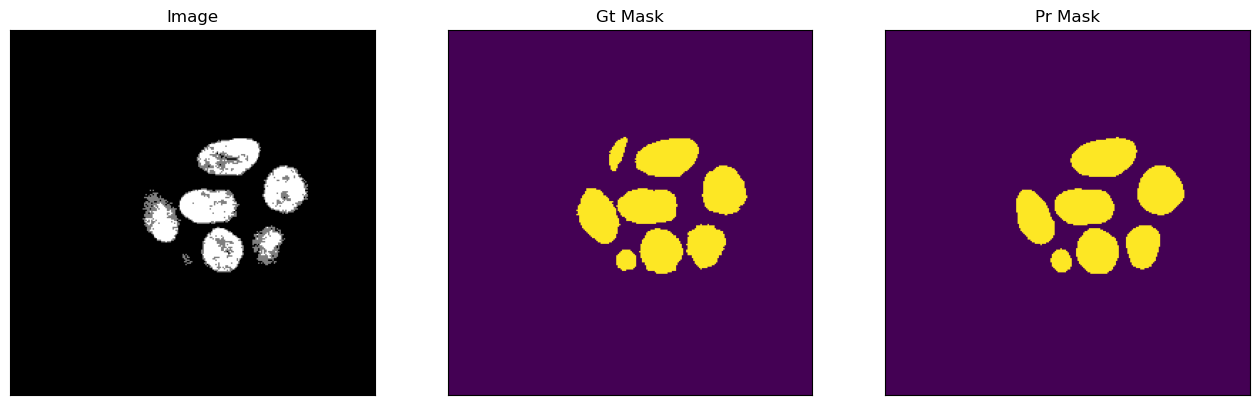

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


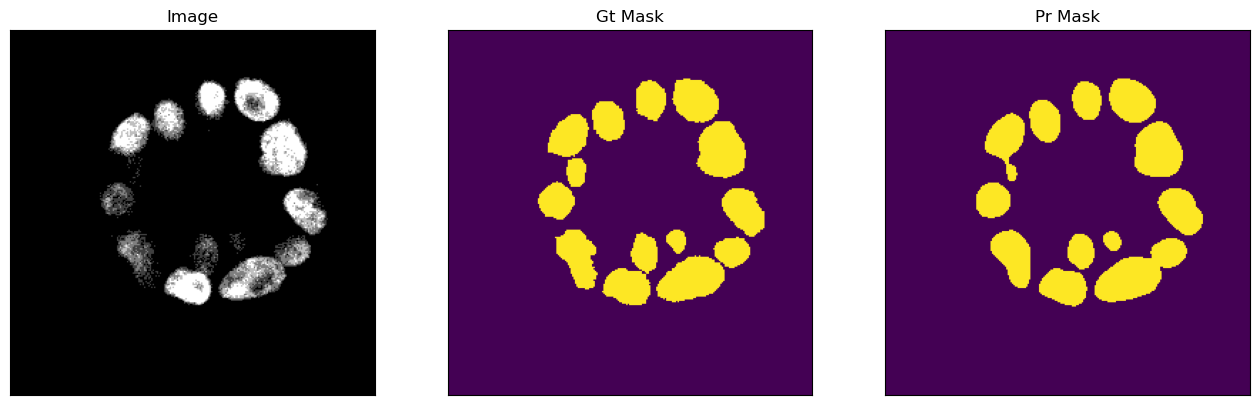

1/1 [==============================] - 0s 43ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (1, 256, 256, 1)


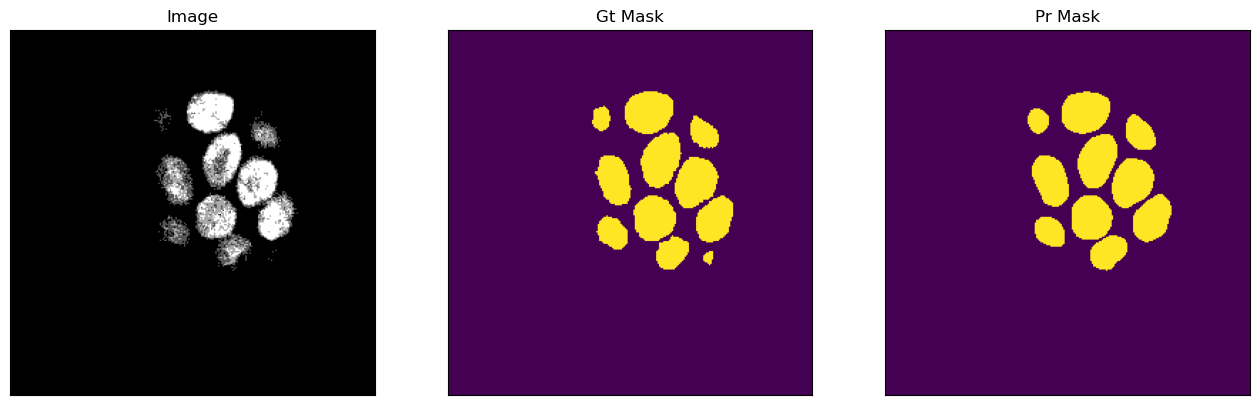

In [43]:
n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n, replace=False)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    print("Image shape:", image.shape)
    print("Ground truth mask shape:", gt_mask.shape)
    print("Prediction mask shape:", pr_mask.shape)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

1/1 [==============================] - 0s 41ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


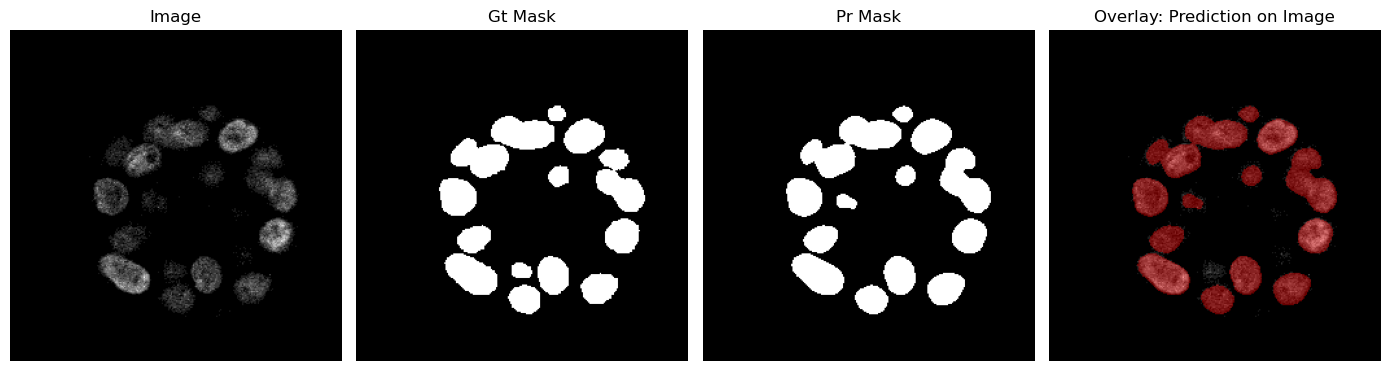

1/1 [==============================] - 0s 41ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


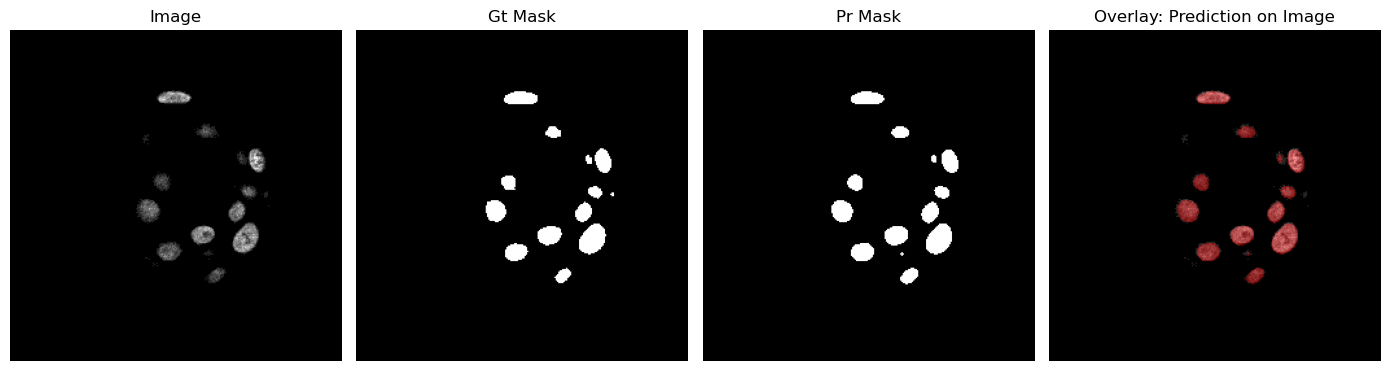

1/1 [==============================] - 0s 42ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


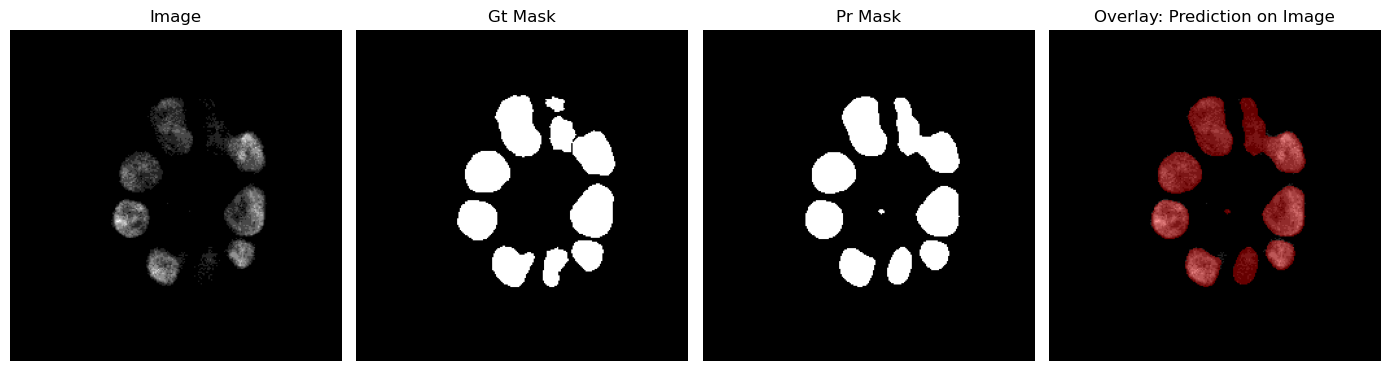

1/1 [==============================] - 0s 48ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


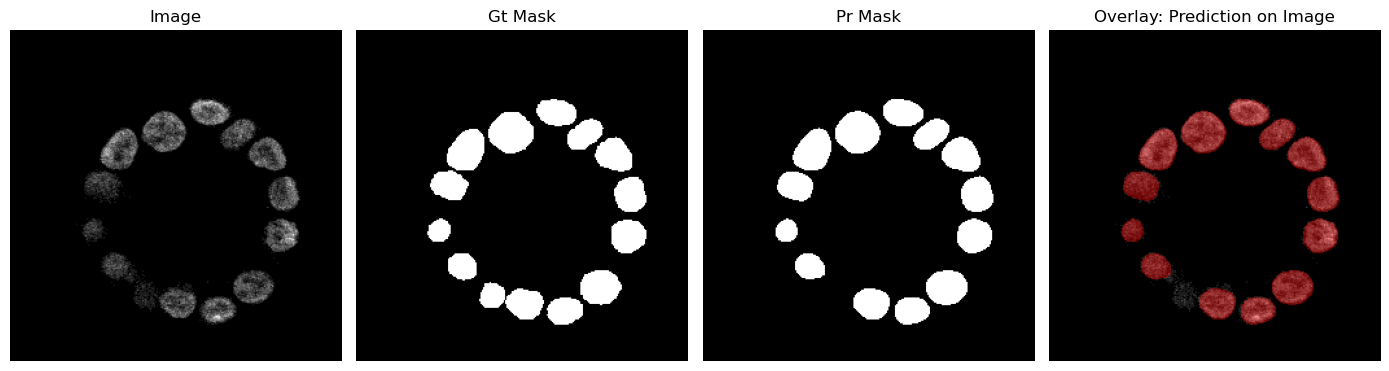

1/1 [==============================] - 0s 41ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


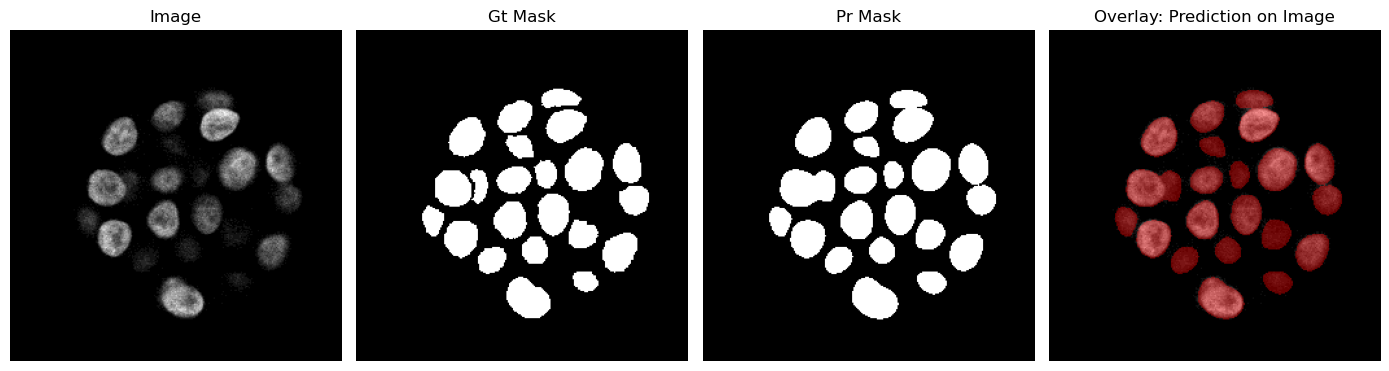

1/1 [==============================] - 0s 56ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


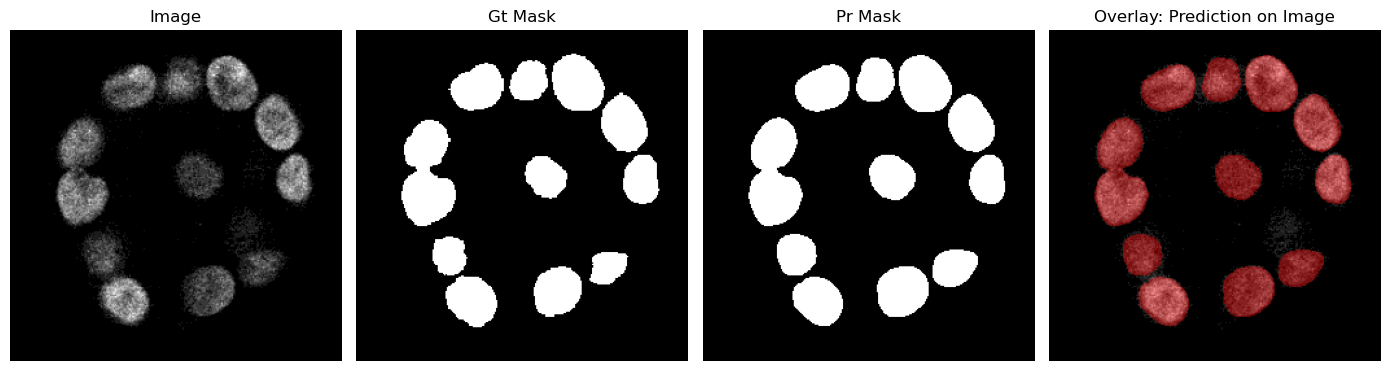

1/1 [==============================] - 0s 56ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


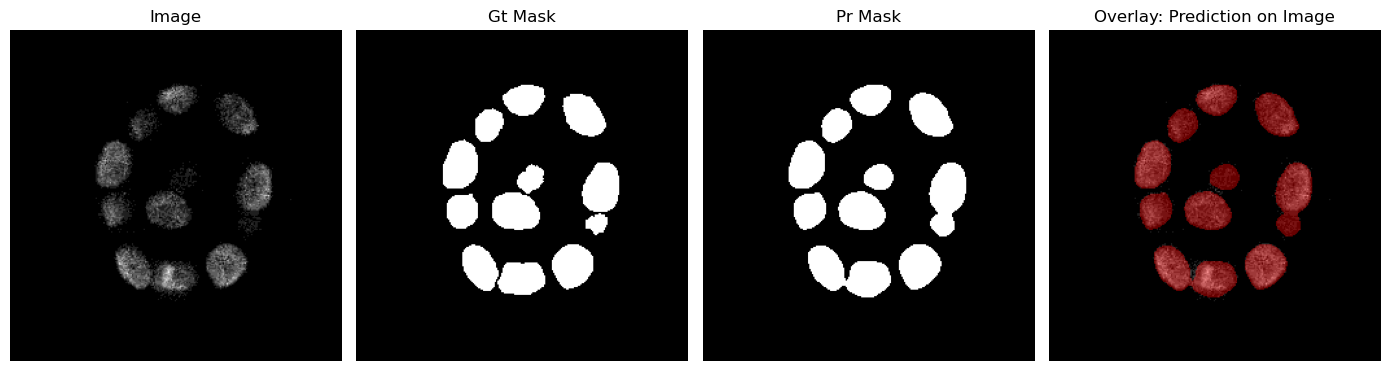

1/1 [==============================] - 0s 86ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


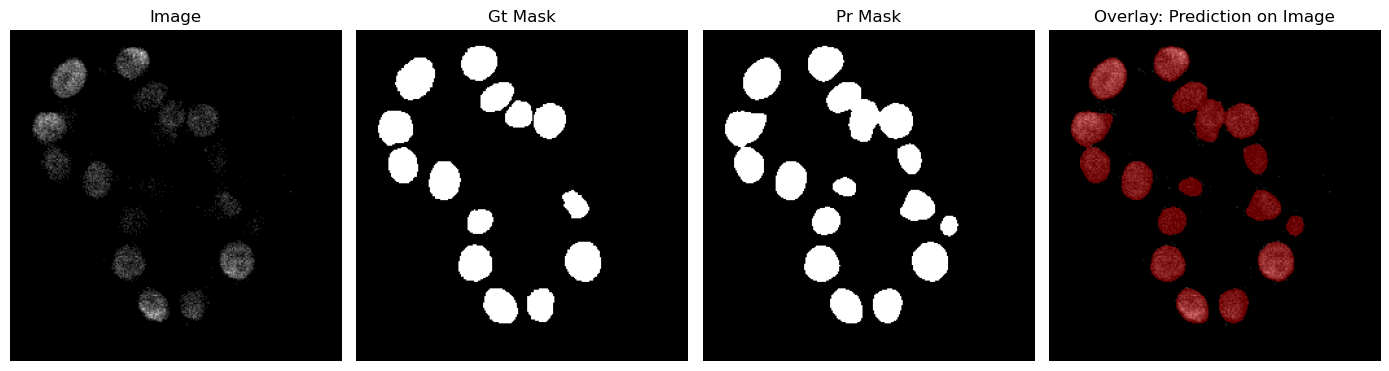

1/1 [==============================] - 0s 57ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


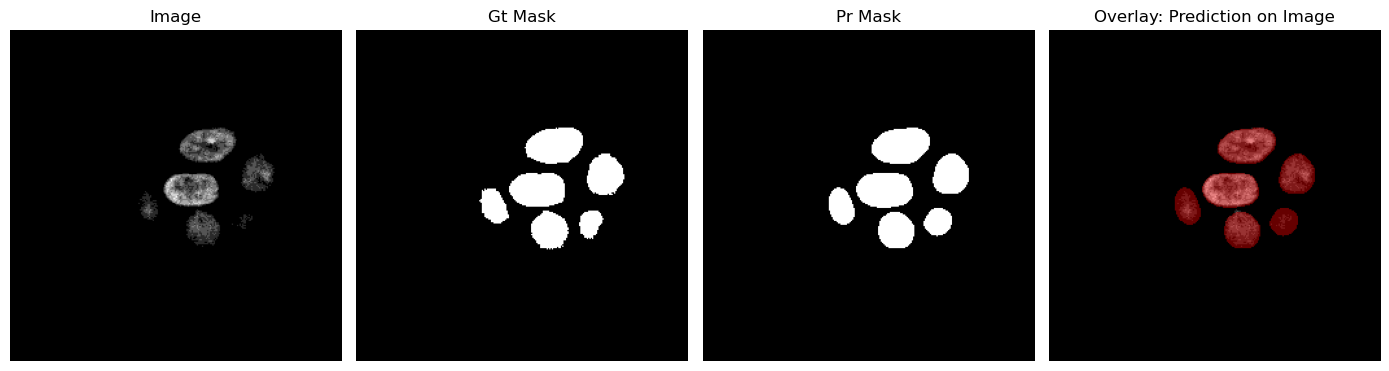

1/1 [==============================] - 0s 47ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


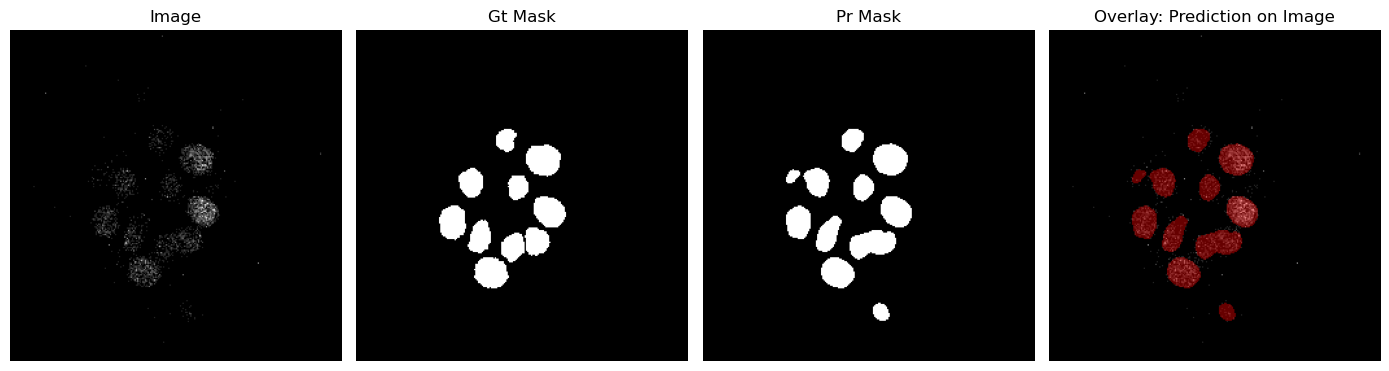

1/1 [==============================] - 0s 51ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


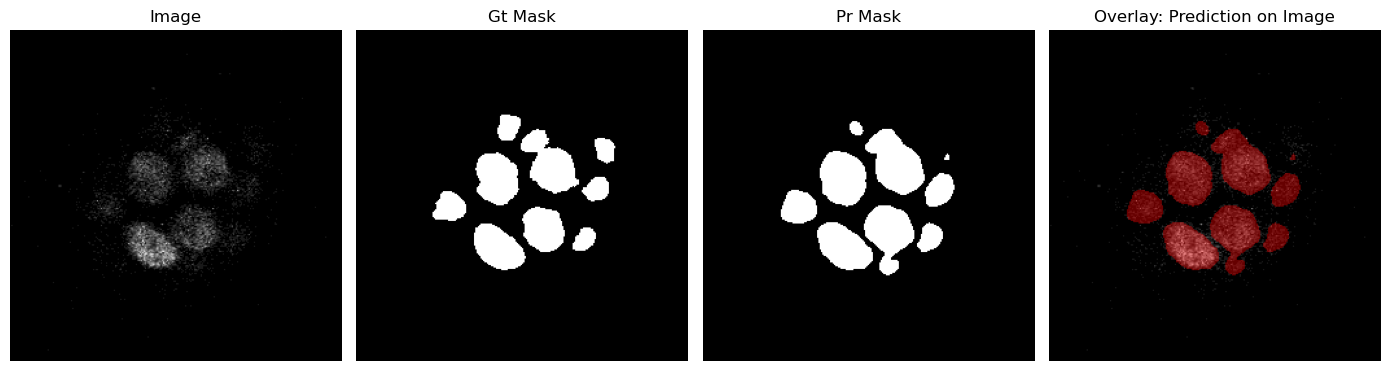

1/1 [==============================] - 0s 85ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


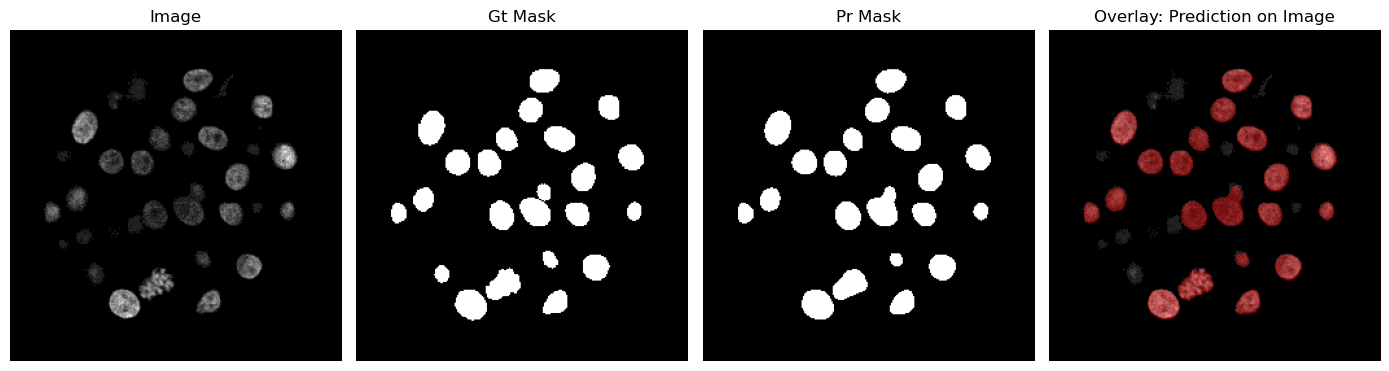

1/1 [==============================] - 0s 105ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


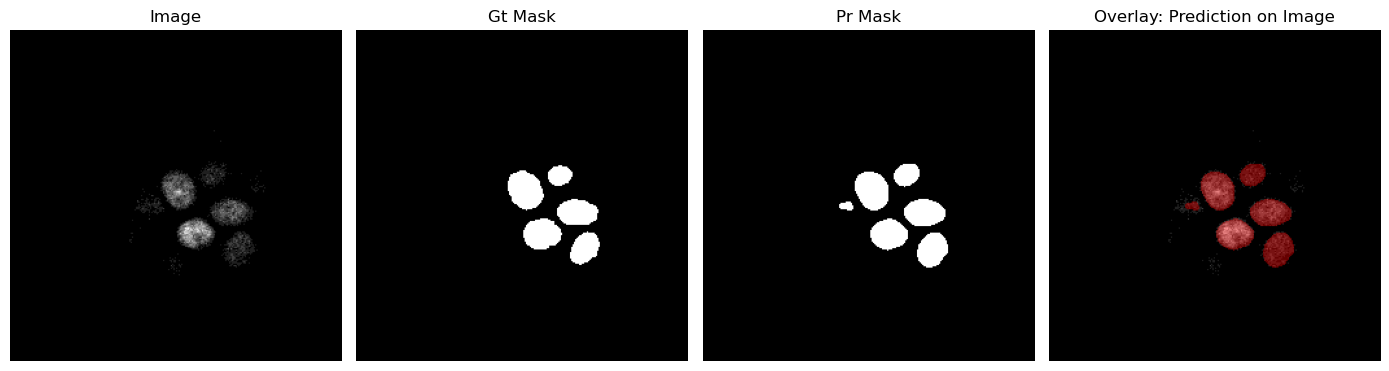

1/1 [==============================] - 0s 42ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


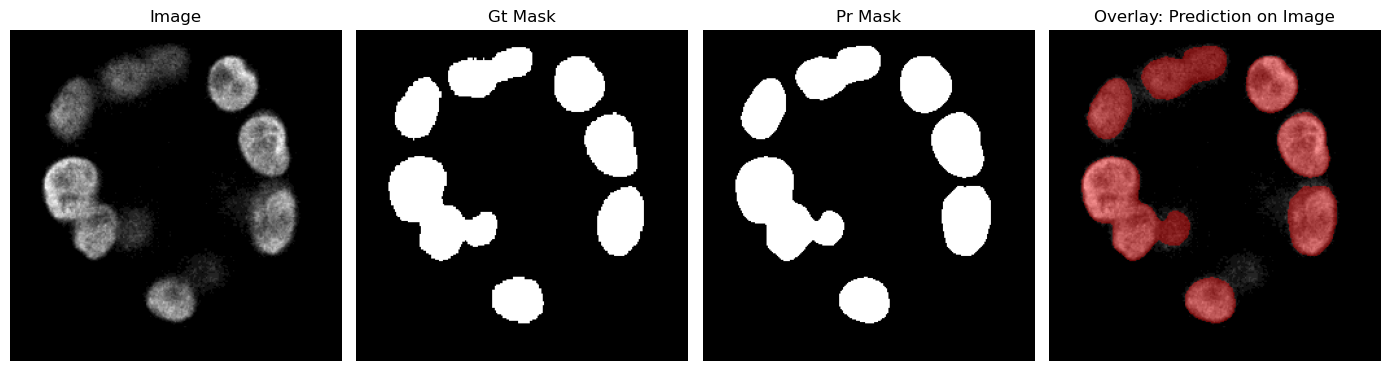

1/1 [==============================] - 0s 83ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


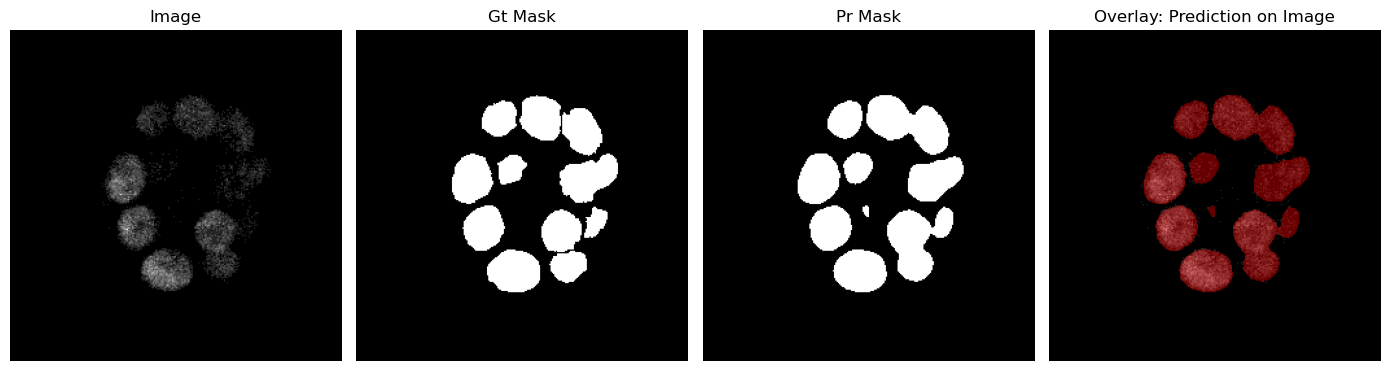

1/1 [==============================] - 0s 60ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


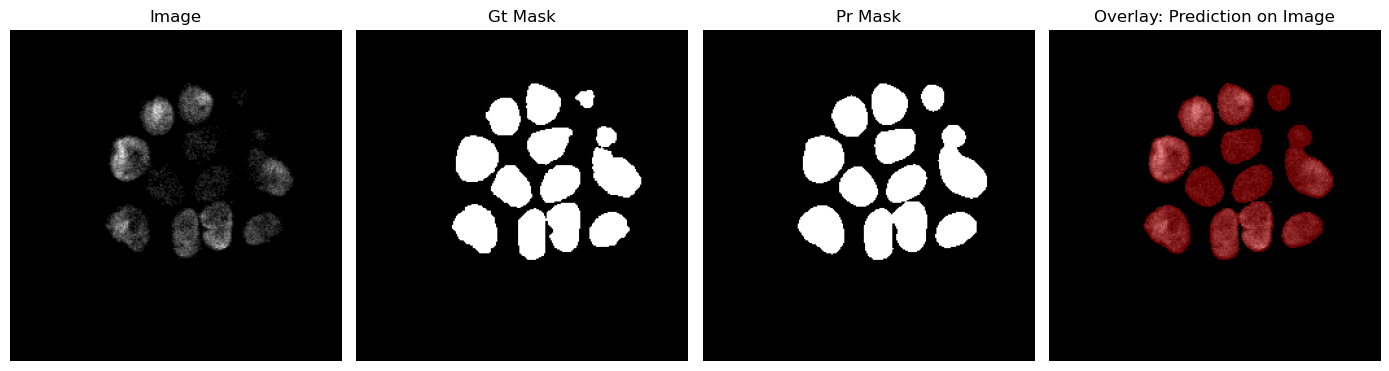

1/1 [==============================] - 0s 41ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


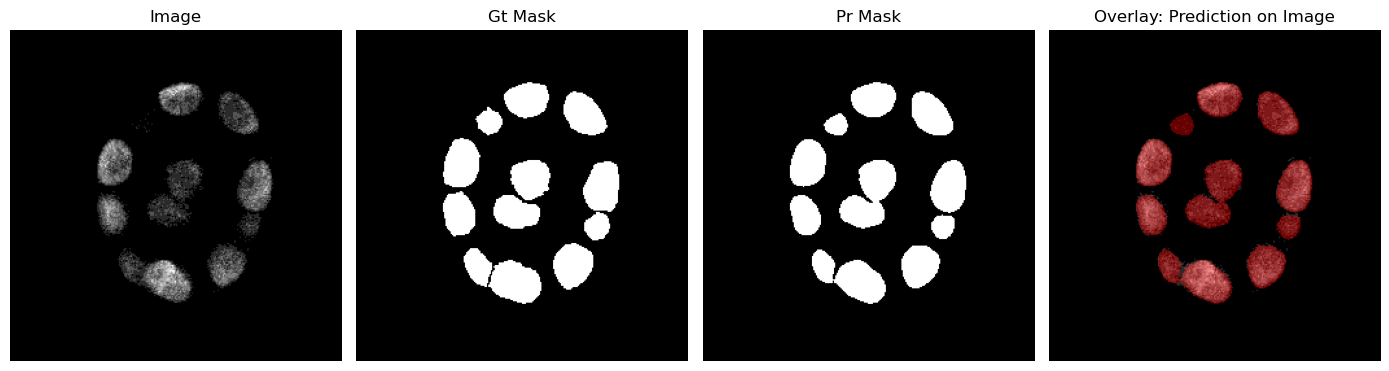

1/1 [==============================] - 0s 40ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


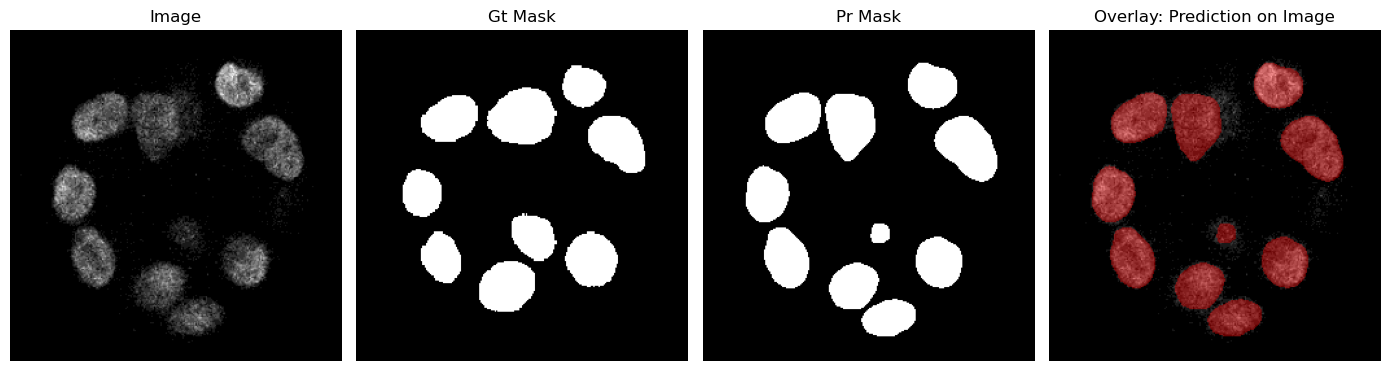

1/1 [==============================] - 0s 41ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


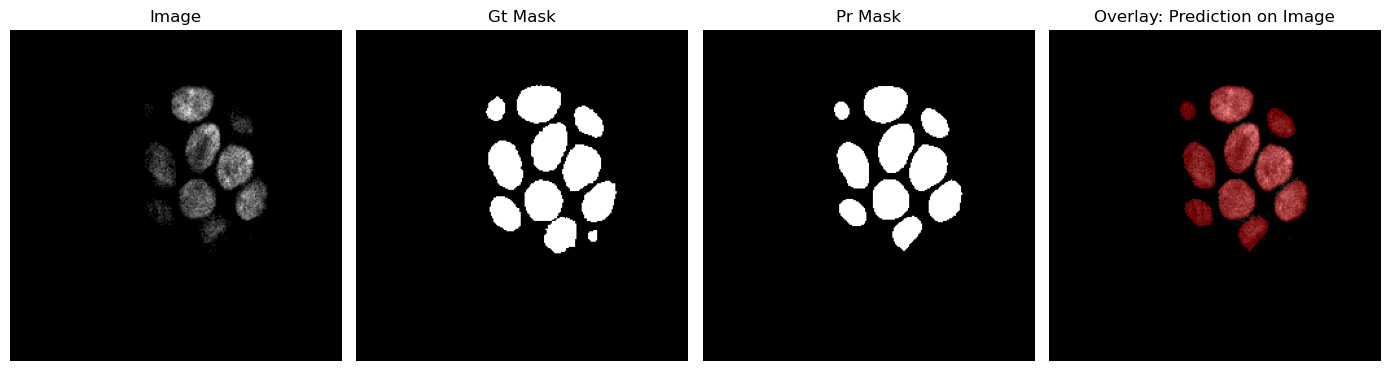

1/1 [==============================] - 0s 39ms/step
Image shape: (1, 256, 256, 3)
Ground truth mask shape: (256, 256, 1)
Prediction mask shape: (256, 256, 1)


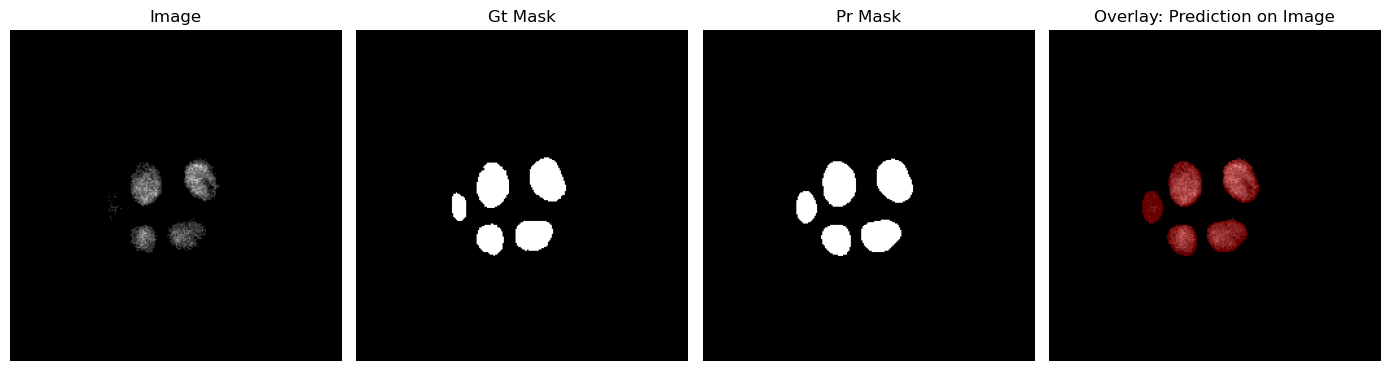

In [44]:
def normalize_for_display(x):
    """Convert any image range to [0,255] uint8 for display."""
    x = np.nan_to_num(x)
    x_min, x_max = x.min(), x.max()
    if x_max - x_min > 0:
        x = (x - x_min) / (x_max - x_min)
    x = (x * 255).astype(np.uint8)
    return x

n = 20
ids = np.random.choice(np.arange(len(test_dataset)), size=n, replace=False)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)[0].round()

    print("Image shape:", image.shape)
    print("Ground truth mask shape:", gt_mask.shape)
    print("Prediction mask shape:", pr_mask.shape)

    # Prepare image for display
    img_vis = normalize_for_display(image.squeeze())

    # Create transparent red overlay
    overlay = img_vis.copy()
    mask = pr_mask[..., 0].astype(bool)
    red = np.zeros_like(img_vis)
    red[..., 0] = 255  # red channel
    alpha = 0.4  # transparency
    overlay = np.where(mask[..., None],
                       (1 - alpha) * img_vis + alpha * red,
                       img_vis).astype(np.uint8)

    # Visualize
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img_vis)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask[..., 0].squeeze(), cmap='gray')
    plt.title("Gt Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pr_mask[..., 0].squeeze(), cmap='gray')
    plt.title("Pr Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay: Prediction on Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



🔹 Showing results for bucket: dataset1.0all
1/1 [==============================] - 0s 41ms/step


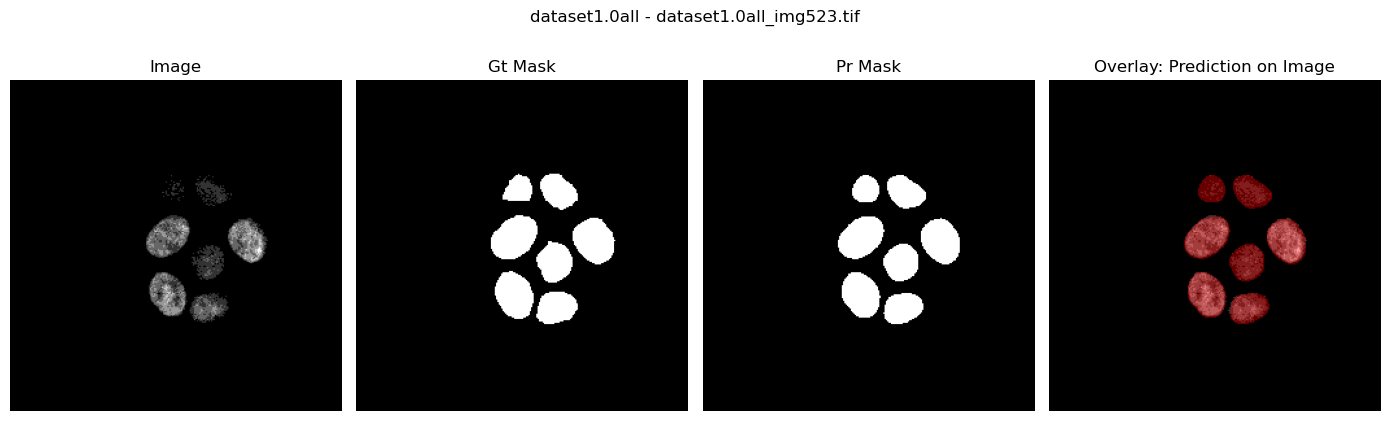

1/1 [==============================] - 0s 41ms/step


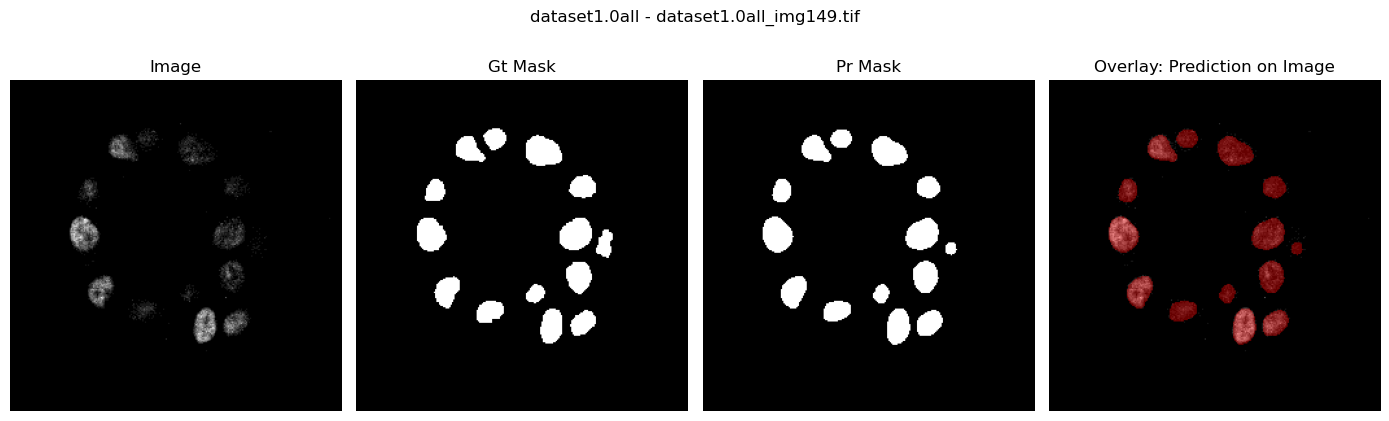

1/1 [==============================] - 0s 41ms/step


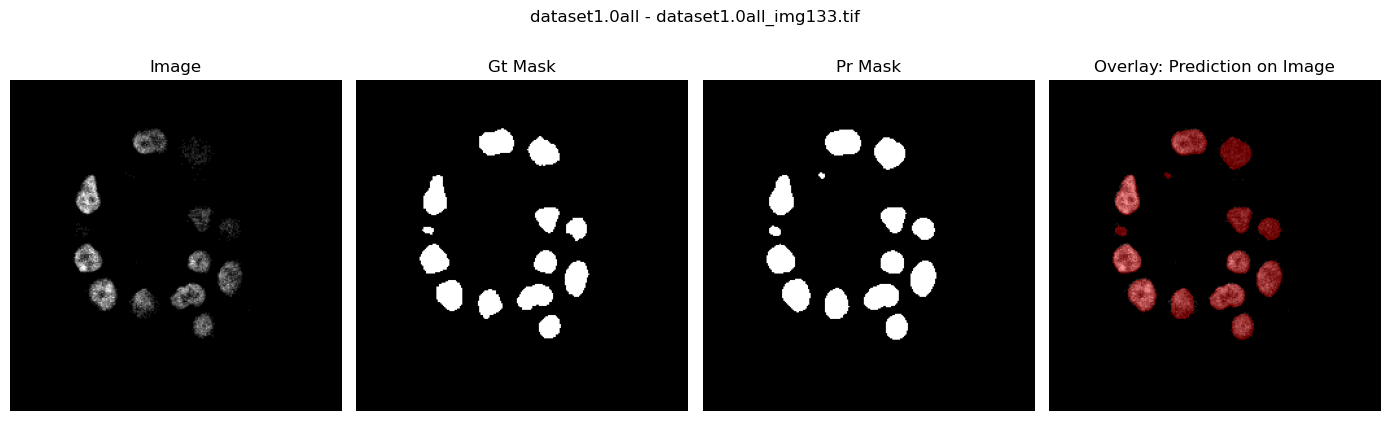


🔹 Showing results for bucket: dataset1.5
1/1 [==============================] - 0s 41ms/step


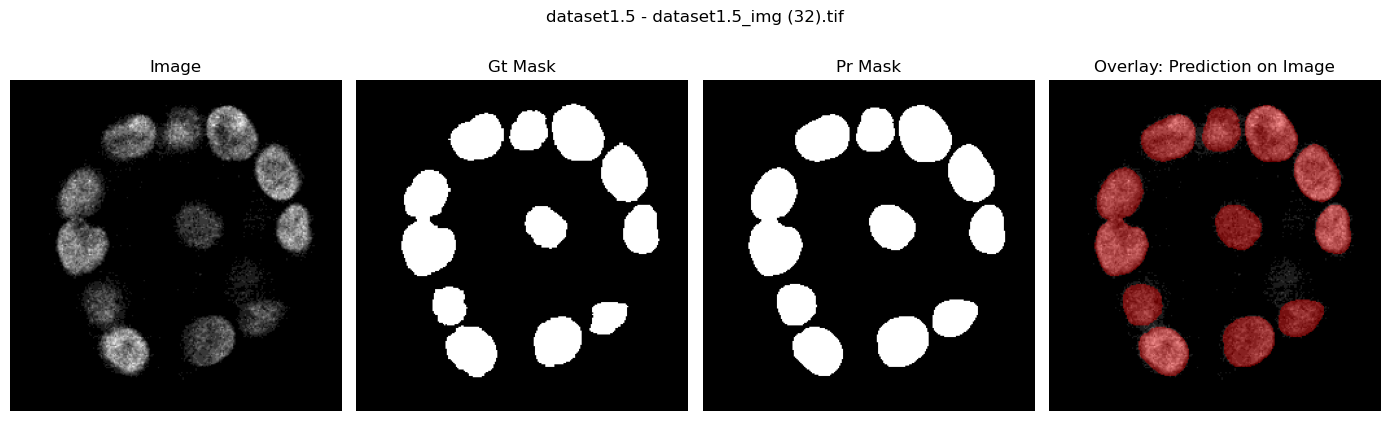

1/1 [==============================] - 0s 46ms/step


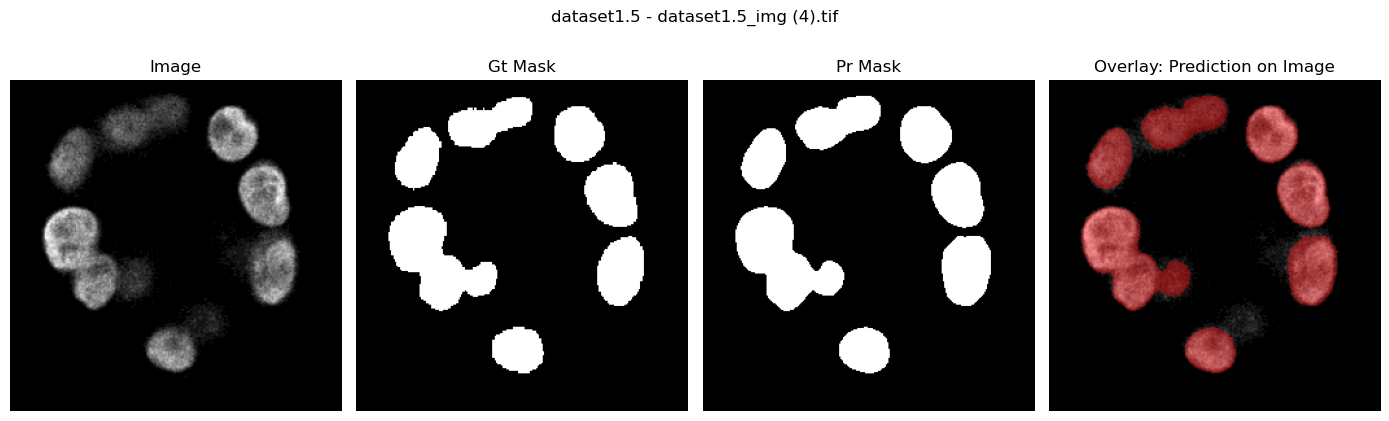

1/1 [==============================] - 0s 46ms/step


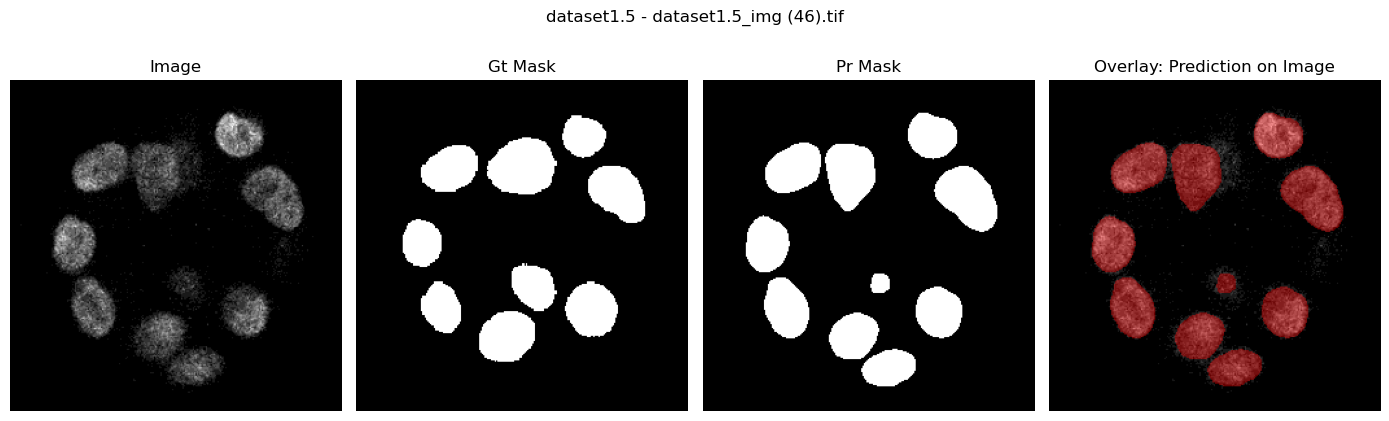


🔹 Showing results for bucket: dataset1.75
1/1 [==============================] - 0s 45ms/step


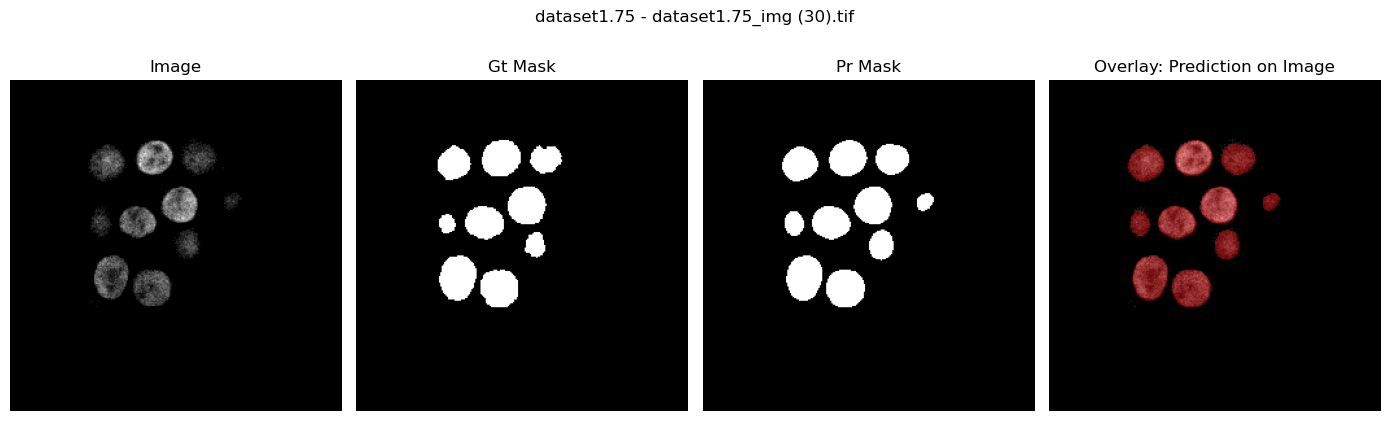

1/1 [==============================] - 0s 43ms/step


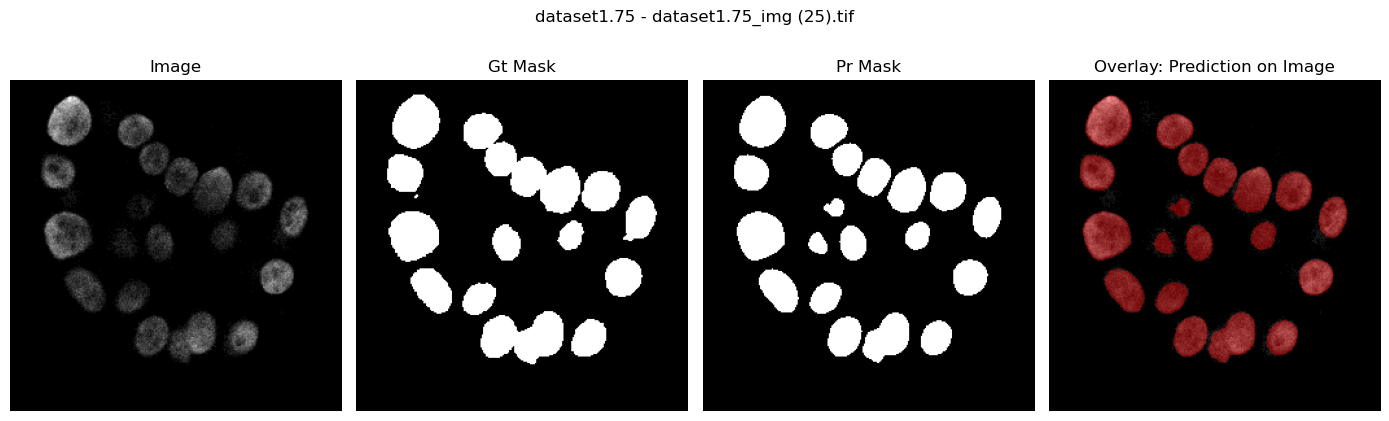

1/1 [==============================] - 0s 44ms/step


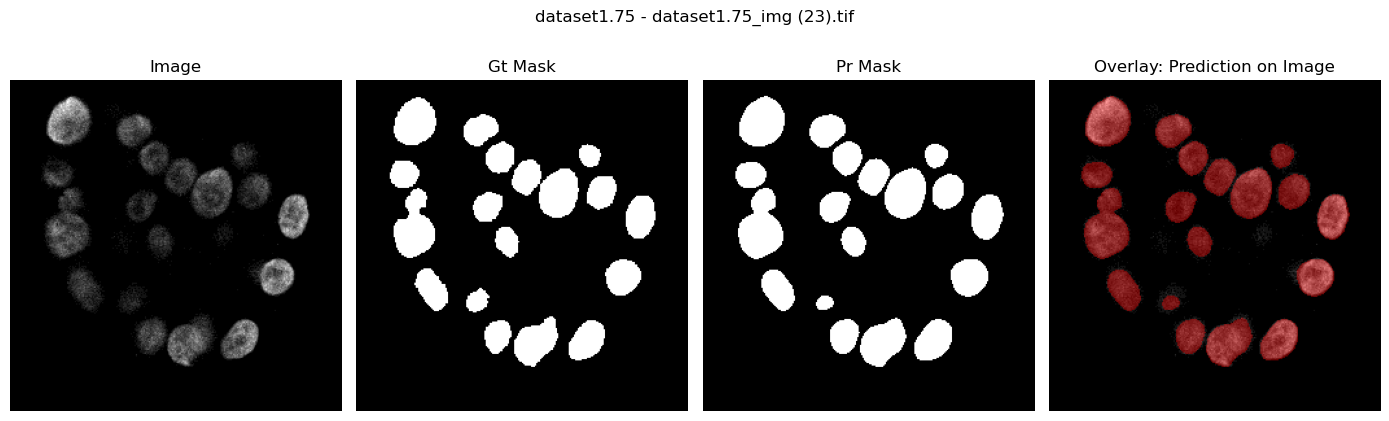


🔹 Showing results for bucket: dataset2.0
1/1 [==============================] - 0s 44ms/step


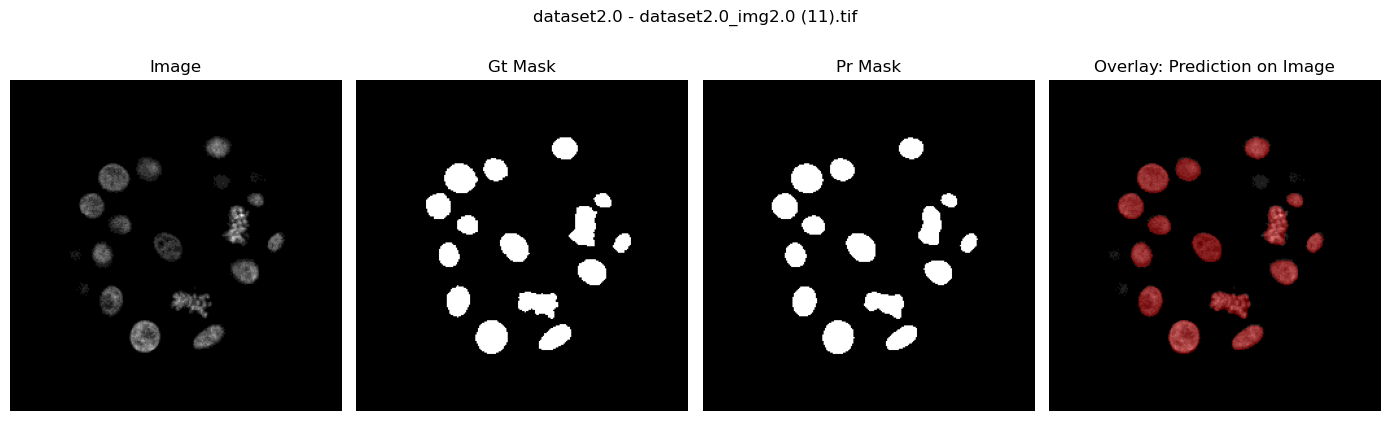

1/1 [==============================] - 0s 44ms/step


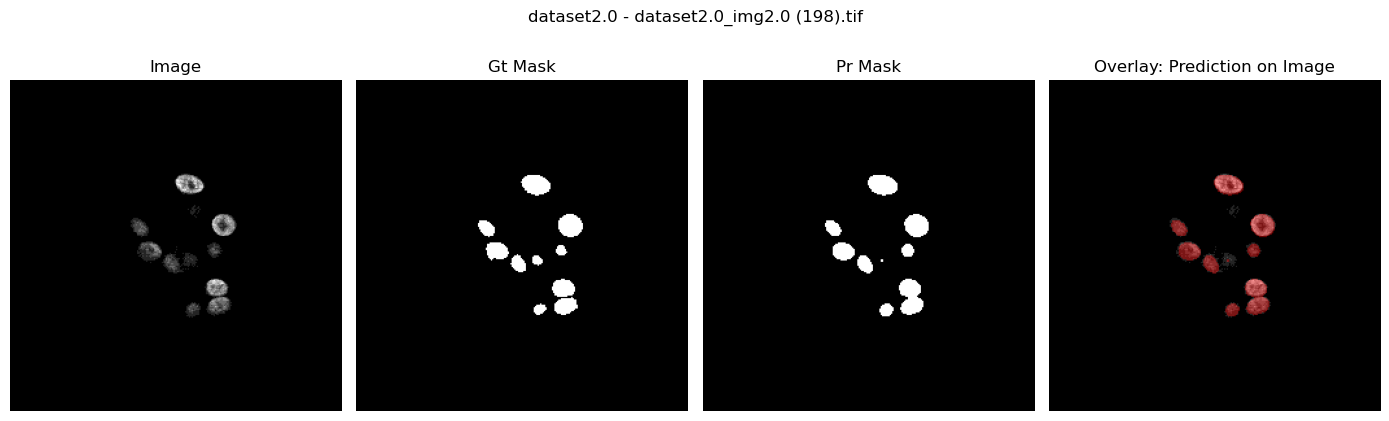

1/1 [==============================] - 0s 43ms/step


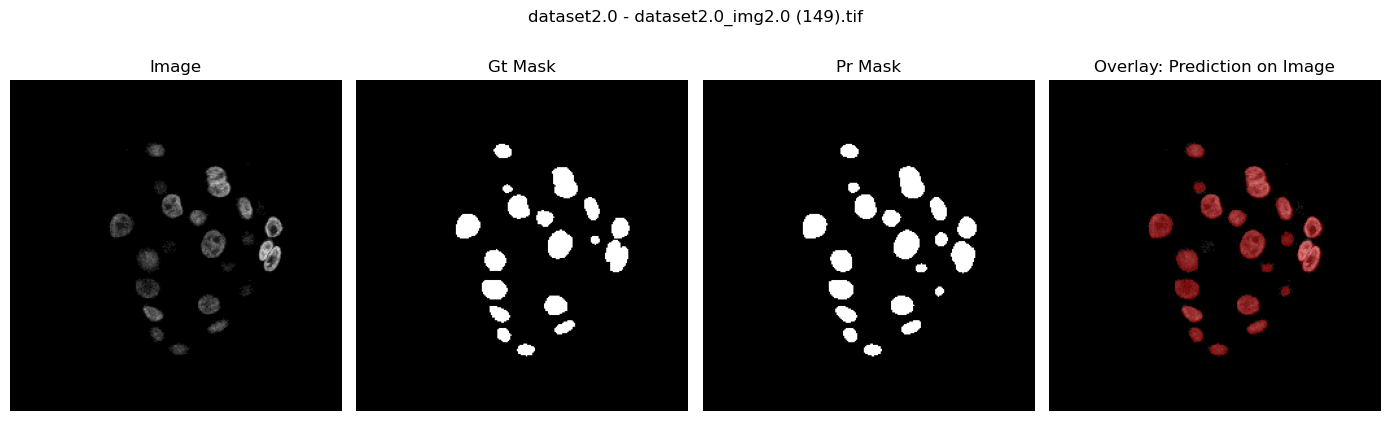

In [45]:
def normalize_for_display(x):
    """Convert any image range to [0,255] uint8 for display."""
    x = np.nan_to_num(x)
    x_min, x_max = x.min(), x.max()
    if x_max - x_min > 0:
        x = (x - x_min) / (x_max - x_min)
    x = (x * 255).astype(np.uint8)
    return x

# Define all bucket prefixes
bucket_prefixes = ["dataset1.0all", "dataset1.5", "dataset1.75", "dataset2.0"]

# Group test images by bucket
bucket_groups = {prefix: [] for prefix in bucket_prefixes}

for img_path in test_image_files:
    for prefix in bucket_prefixes:
        if prefix in os.path.basename(img_path):
            bucket_groups[prefix].append(img_path)
            break

# Display 3 random samples from each bucket
for prefix, img_list in bucket_groups.items():
    if not img_list:
        print(f"⚠️ No test images found for bucket: {prefix}")
        continue

    print(f"\n🔹 Showing results for bucket: {prefix}")
    sample_paths = random.sample(img_list, min(3, len(img_list)))

    for img_path in sample_paths:
        base_name = os.path.basename(img_path)
        mask_path = [m for m in test_label_files if base_name in m]
        if not mask_path:
            print(f"⚠️ No matching mask for {base_name}")
            continue
        mask_path = mask_path[0]

        idx = next((i for i, path in enumerate(test_image_files) if path == img_path), None)
        if idx is None:
            continue

        # Load and predict
        image, gt_mask = test_dataset[idx]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)[0].round()
        img_vis = normalize_for_display(image.squeeze())

        # Create transparent red overlay
        overlay = img_vis.copy()
        mask = pr_mask[..., 0].astype(bool)
        red = np.zeros_like(img_vis)
        red[..., 0] = 255
        alpha = 0.4
        overlay = np.where(mask[..., None],
                           (1 - alpha) * img_vis + alpha * red,
                           img_vis).astype(np.uint8)

        # Visualization
        plt.figure(figsize=(14, 4))
        plt.suptitle(f"{prefix} - {base_name}", fontsize=12, y=1.05)

        plt.subplot(1, 4, 1)
        plt.imshow(img_vis)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(gt_mask[..., 0].squeeze(), cmap='gray')
        plt.title("Gt Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(pr_mask[..., 0].squeeze(), cmap='gray')
        plt.title("Pr Mask")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(overlay)
        plt.title("Overlay: Prediction on Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()



🔹 Showing results for bucket: dataset1.0all (found 46 test images)
1/1 [==============================] - 0s 28ms/step


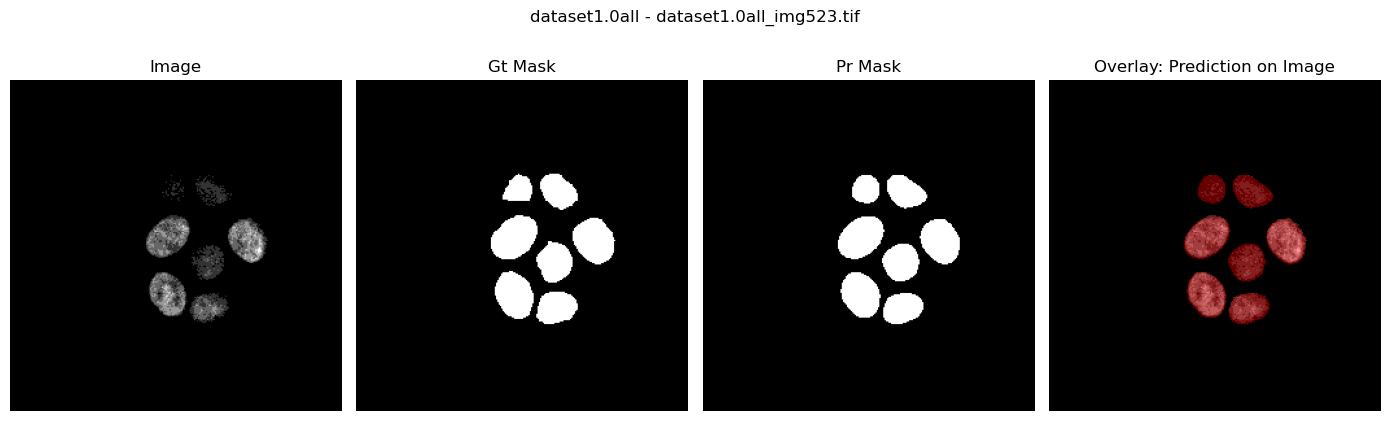

1/1 [==============================] - 0s 34ms/step


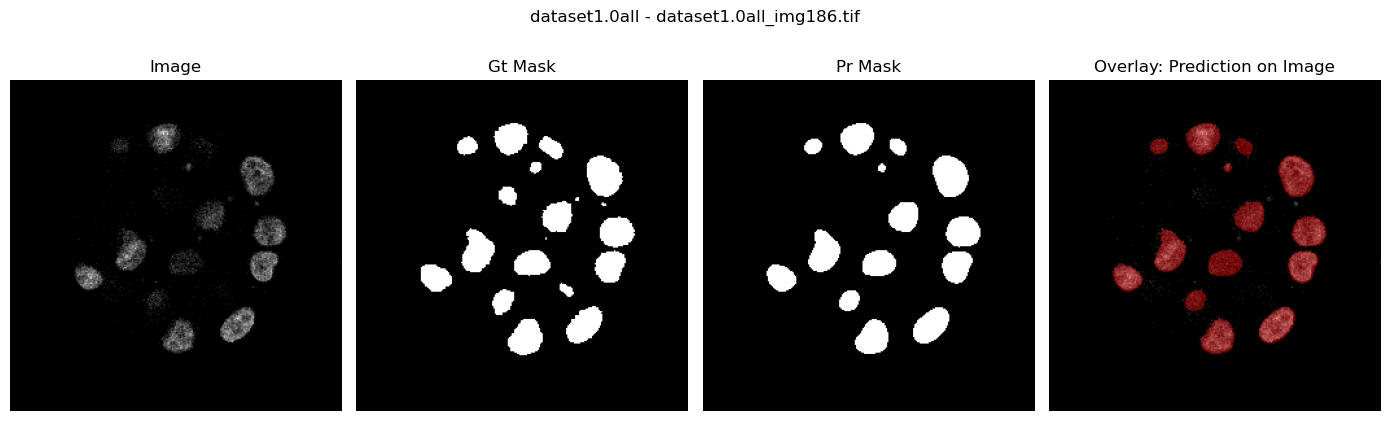

1/1 [==============================] - 0s 31ms/step


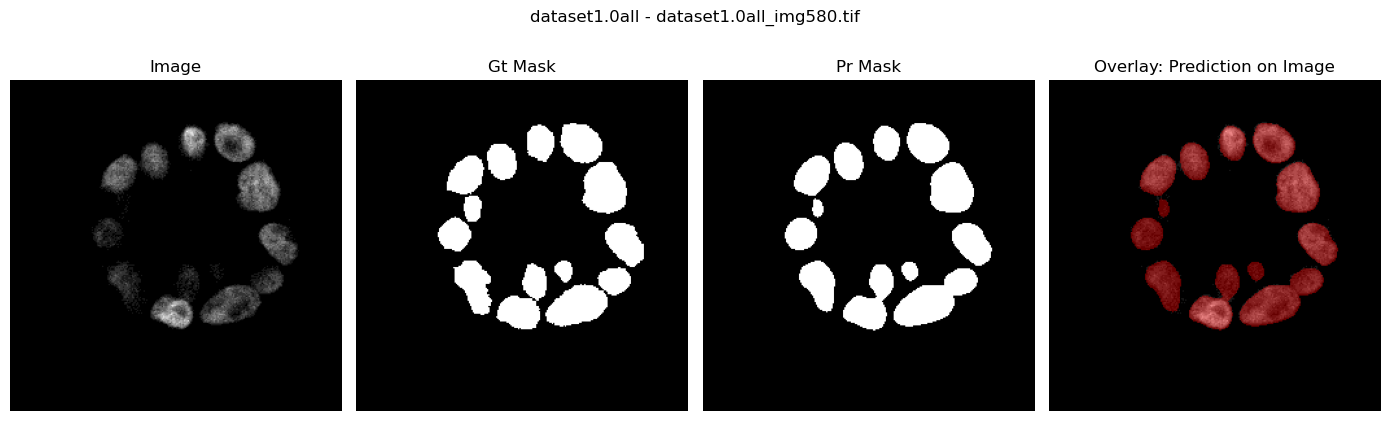


🔹 Showing results for bucket: dataset1.5 (found 5 test images)
1/1 [==============================] - 0s 30ms/step


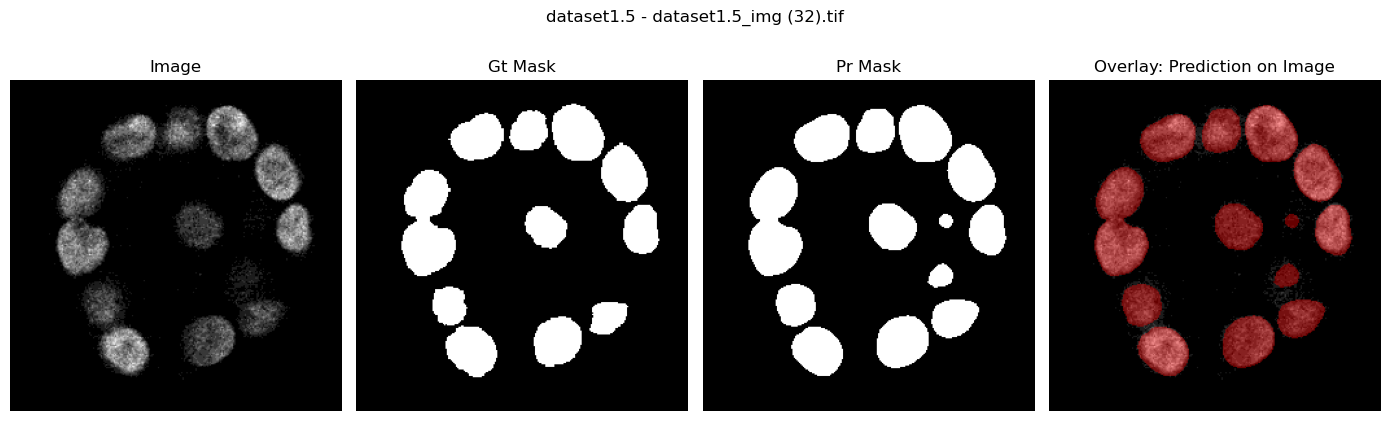

1/1 [==============================] - 0s 30ms/step


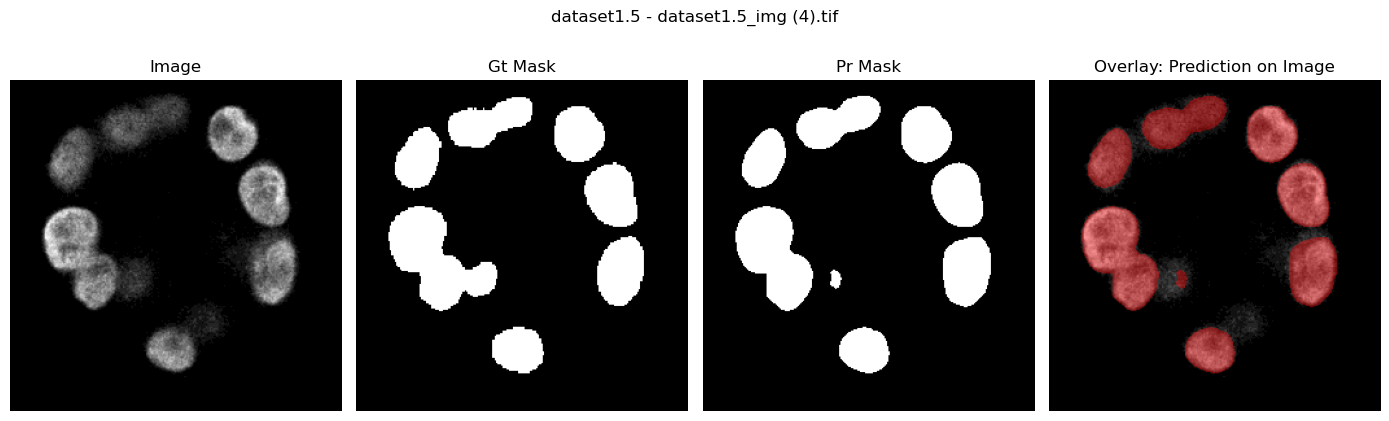

1/1 [==============================] - 0s 29ms/step


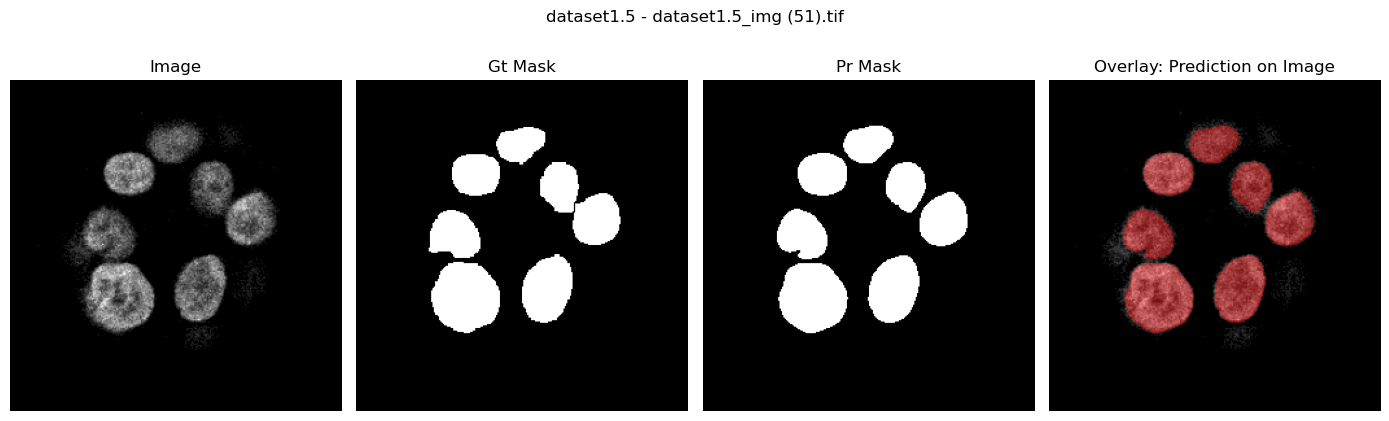


🔹 Showing results for bucket: dataset1.75 (found 14 test images)
1/1 [==============================] - 0s 29ms/step


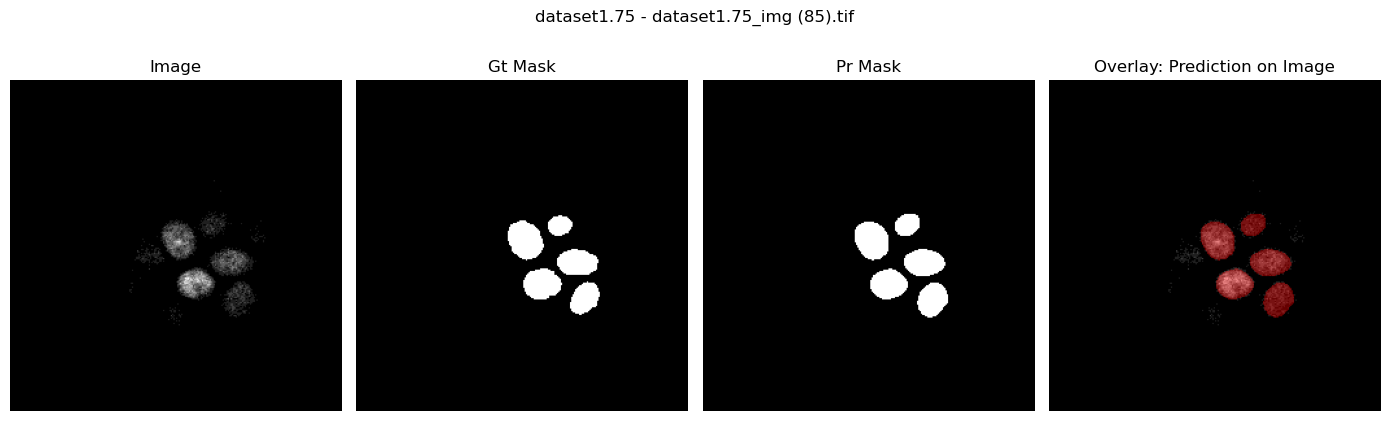

1/1 [==============================] - 0s 30ms/step


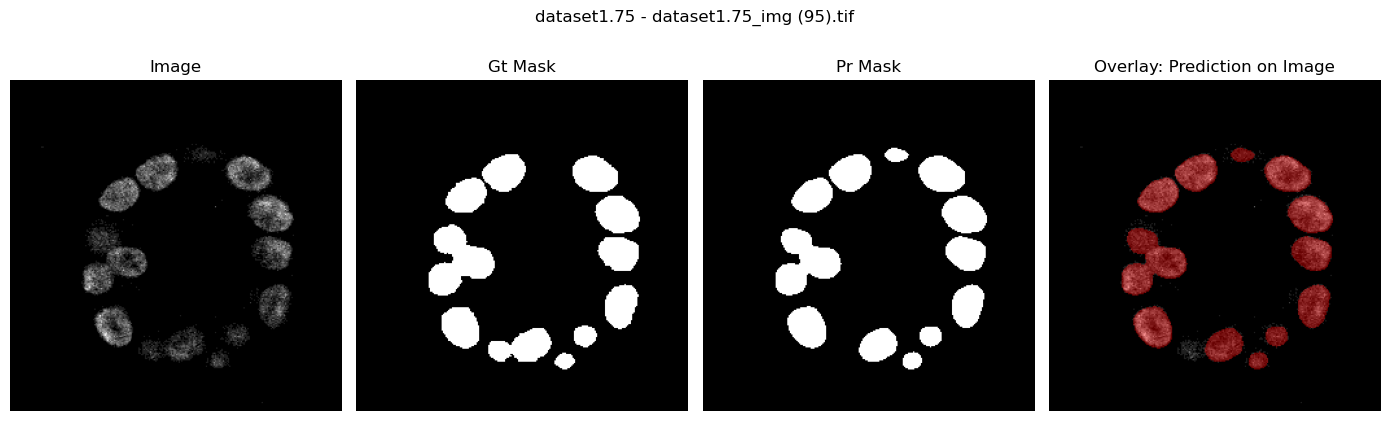

1/1 [==============================] - 0s 29ms/step


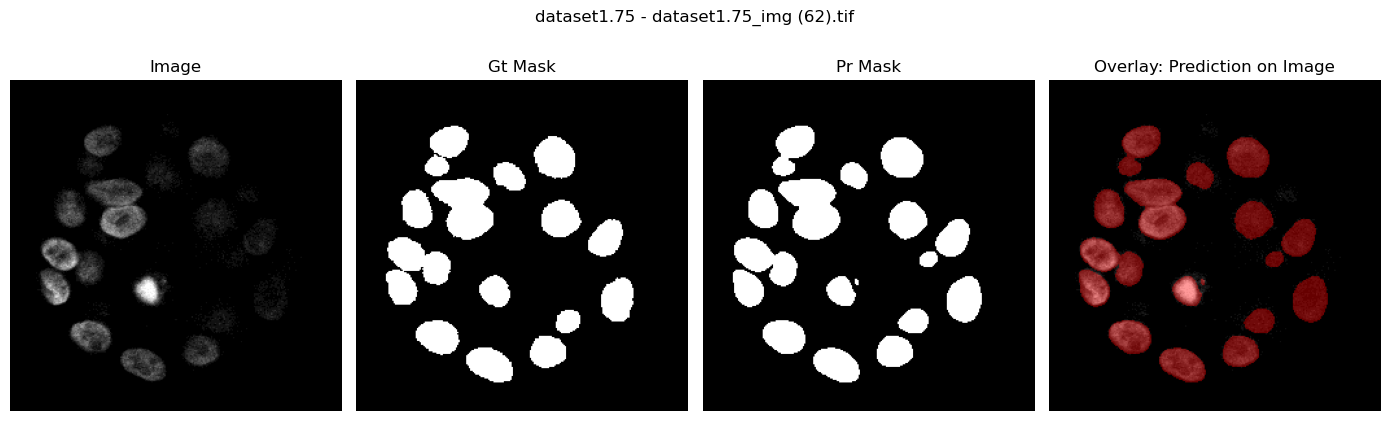


🔹 Showing results for bucket: dataset2.0 (found 17 test images)
1/1 [==============================] - 0s 30ms/step


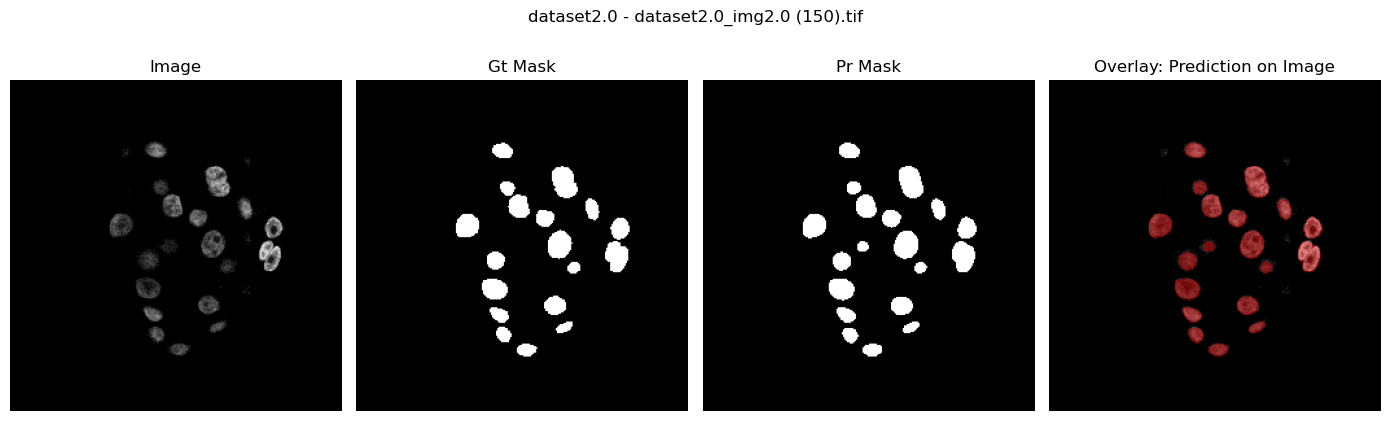

1/1 [==============================] - 0s 30ms/step


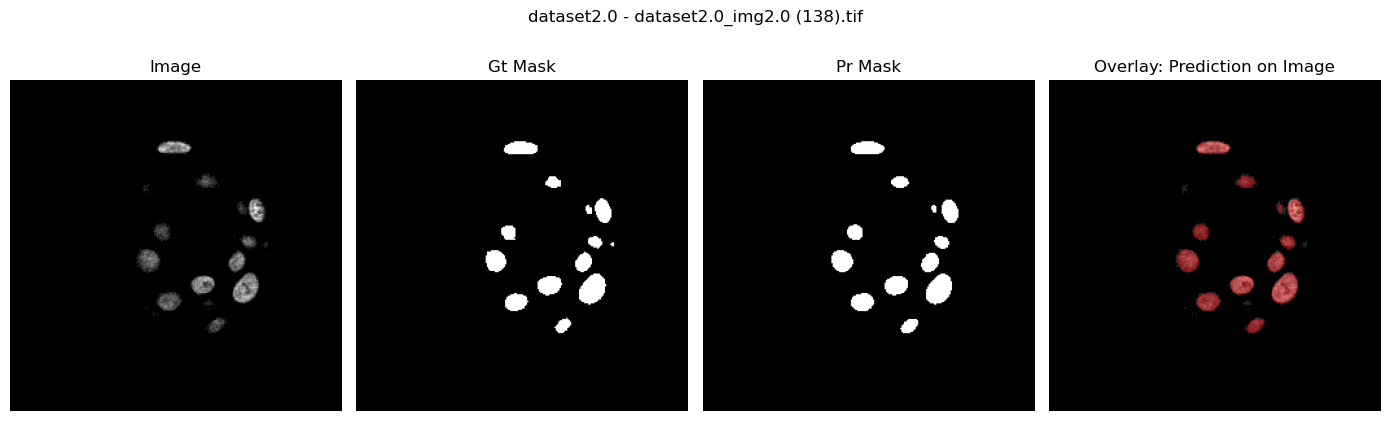

1/1 [==============================] - 0s 30ms/step


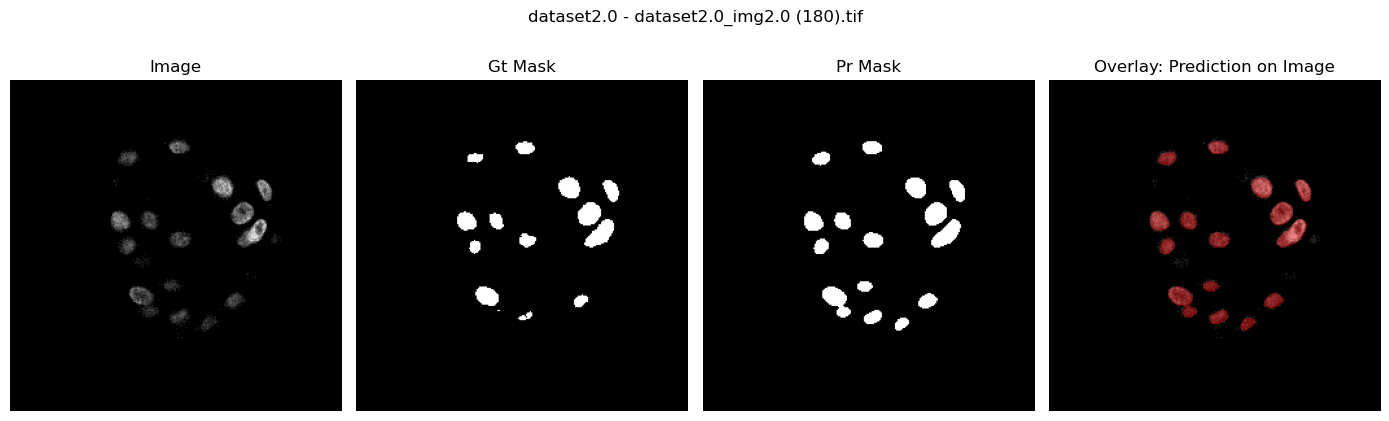

In [53]:
# --- Display up to 3 random samples from each bucket ---
for prefix, img_list in bucket_groups.items():
    if not img_list:
        print(f"⚠️ No test images found for bucket: {prefix}")
        continue

    print(f"\n🔹 Showing results for bucket: {prefix} (found {len(img_list)} test images)")
    
    # Use all if less than 3 images, else random 3
    if len(img_list) <= 3:
        sample_paths = img_list
    else:
        sample_paths = random.sample(img_list, 3)
    
    for img_path in sample_paths:
        base_name = os.path.basename(img_path)
        mask_path = [m for m in test_label_files if base_name in m]
        if not mask_path:
            print(f"⚠️ No matching mask for {base_name}")
            continue
        mask_path = mask_path[0]

        # Find dataset index
        idx = next((i for i, path in enumerate(test_image_files) if path == img_path), None)
        if idx is None:
            continue

        # Load and predict
        image, gt_mask = test_dataset[idx]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)[0].round()
        img_vis = normalize_for_display(image.squeeze())

        # Overlay creation
        overlay = img_vis.copy()
        mask = pr_mask[..., 0].astype(bool)
        red = np.zeros_like(img_vis)
        red[..., 0] = 255
        alpha = 0.4
        overlay = np.where(mask[..., None],
                           (1 - alpha) * img_vis + alpha * red,
                           img_vis).astype(np.uint8)

        # Visualization
        plt.figure(figsize=(14, 4))
        plt.suptitle(f"{prefix} - {base_name}", fontsize=12, y=1.05)

        plt.subplot(1, 4, 1)
        plt.imshow(img_vis)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(gt_mask[..., 0].squeeze(), cmap='gray')
        plt.title("Gt Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(pr_mask[..., 0].squeeze(), cmap='gray')
        plt.title("Pr Mask")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(overlay)
        plt.title("Overlay: Prediction on Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [46]:
from collections import defaultdict
import os

buckets = ["dataset1.0all", "dataset1.5", "dataset1.75", "dataset2.0"]
splits = {"train": train_image_files, "val": val_image_files, "test": test_image_files}
summary = defaultdict(lambda: {"train":0, "val":0, "test":0})

for split_name, split_files in splits.items():
    for img in split_files:
        base = os.path.basename(img)
        for bucket in buckets:
            if base.startswith(bucket + "_"):
                summary[bucket][split_name] += 1
                break

for bucket, counts in summary.items():
    print(f"{bucket}: Train={counts['train']}, Val={counts['val']}, Test={counts['test']}")


dataset2.0: Train=159, Val=22, Test=17
dataset1.75: Train=86, Val=14, Test=14
dataset1.0all: Train=362, Val=45, Test=46
dataset1.5: Train=48, Val=1, Test=5


In [47]:
SAVE_ROOT = "Bucket_Results_inceptionresnetv2"
os.makedirs(SAVE_ROOT, exist_ok=True)

def normalize_for_display(x):
    x = np.nan_to_num(x)
    x_min, x_max = x.min(), x.max()
    if x_max - x_min > 0:
        x = (x - x_min) / (x_max - x_min)
    return (x * 255).astype(np.uint8)

bucket_prefixes = ["dataset1.0all", "dataset1.5", "dataset1.75", "dataset2.0"]

bucket_groups = {prefix: [] for prefix in bucket_prefixes}

for img_path in test_image_files:
    base = os.path.basename(img_path)
    for prefix in bucket_prefixes:
        if base.startswith(prefix + "_"):
            bucket_groups[prefix].append(img_path)
            break

for prefix, img_list in bucket_groups.items():

    if not img_list:
        print(f"⚠️ No test images for {prefix}")
        continue

    SAVE_DIR = os.path.join(SAVE_ROOT, prefix)
    os.makedirs(SAVE_DIR, exist_ok=True)

    print(f"\n🔹 Processing bucket: {prefix}")

    sample_paths = img_list if len(img_list) <= 3 else random.sample(img_list, 3)

    for img_path in sample_paths:

        base_name = os.path.basename(img_path).replace(".tif","")

        mask_path = [m for m in test_label_files if base_name in m]
        if not mask_path:
            print(f"⚠ No matching mask for {base_name}")
            continue
        mask_path = mask_path[0]

        idx = next((i for i, p in enumerate(test_image_files) if p == img_path), None)
        if idx is None:
            continue

        # Load & Predict
        image, gt_mask = test_dataset[idx]
        image_exp = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image_exp)[0].round()

        img_vis = normalize_for_display(image.squeeze())

        # Create Overlay
        overlay = img_vis.copy()
        mask = pr_mask[..., 0].astype(bool)
        red = np.zeros_like(img_vis)
        red[..., 0] = 255
        alpha = 0.40
        overlay = np.where(mask[..., None],
                           (1 - alpha) * img_vis + alpha * red,
                           img_vis).astype(np.uint8)

        # Save

        cv2.imwrite(os.path.join(SAVE_DIR, f"{base_name}_image.png"),
                    cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR))

        cv2.imwrite(os.path.join(SAVE_DIR, f"{base_name}_gt.png"),
                    (gt_mask[...,0].squeeze()*255).astype(np.uint8))

        cv2.imwrite(os.path.join(SAVE_DIR, f"{base_name}_pred.png"),
                    (pr_mask[...,0].squeeze()*255).astype(np.uint8))

        cv2.imwrite(os.path.join(SAVE_DIR, f"{base_name}_overlay.png"),
                    cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

        print(f"   💾 Saved → {base_name}_xxxx.png")



🔹 Processing bucket: dataset1.0all
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.0all_img177_xxxx.png
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.0all_img139_xxxx.png
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.0all_img588_xxxx.png

🔹 Processing bucket: dataset1.5
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.5_img (4)_xxxx.png
1/1 [==============================] - 0s 43ms/step
   💾 Saved → dataset1.5_img (51)_xxxx.png
1/1 [==============================] - 0s 44ms/step
   💾 Saved → dataset1.5_img (46)_xxxx.png

🔹 Processing bucket: dataset1.75
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.75_img (50)_xxxx.png
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.75_img (15)_xxxx.png
1/1 [==============================] - 0s 42ms/step
   💾 Saved → dataset1.75_img (95)_xxxx.png

🔹 Processing bucket: dataset2.0
1/1 [========